# Salary Classification

## Introduction

In this assignment, the task is to predict salary ranges based on a 2018 survey conducted by Kaggle called the "2018 ML & DS Survey Challenge". In order to do so, 5 primary steps are followed in this assignment which are listed below.

0. Preliminaries
1. Data Cleaning
    - 1.1 Simplify Data
    - 1.2 Encode Features
        - One hot encoding
    - 1.3 Missing Values
        - 1.3.1 Removing Missing Values
        - 1.3.2 Filling Missing Values
    - 1.4 Complete Cleaned Data
        - one hot encode, label encode
2. Exploratory Data Analysis
3. Feature Selection
    - 3.1 Feature Engineering
    - 3.2 Feature Selection
    - 3.3 Principle Component Analysis
4. Model Implementation
    - 4.1 Logistic Regression
    - 4.2 Confusion Matrix
    - 4.3 Cross Validation
5. Model Tuning
6. Testing and Discussion

## Preliminaries

In [1]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import collections
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn import model_selection
# The following line is needed to show plots inline in notebooks
%matplotlib inline 

In [2]:
# read CSV file
data = pd.read_csv('Kaggle_Salary.csv')
# drop row index 0 because it holds the Questions (inplace is to remove permanently)
data.drop(data.index[0], inplace=True)

/home/aaron/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,3,9,11,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1. Data Cleaning

In this section, the dataset provided is cleaned by the following steps:
1. Simplify the data by eliminating categories within features with low frequencies
2. Removed features as well as survey entries with a high amount of missing values
    - For features with a low amount of missing values, alternative methods are applied to fill them
3. Encode the data via techniques such as label encoding and one hot encoding
4. Form complete cleaned dataset

### 1.1 Simplify Data

In this section, I will be going through a few features to take a look at what kind of data is available. As described previously, categories with low counts will be merged with others to reduce the amount of options per feature. The motivation behind this is to create less crowded graphs for exploratory analysis as well as to simplify the data for better and easier understanding.

In [3]:
# The raw data has 15429 entries with 397 features
data.shape

(15429, 397)

To start, the following function takes 2 arguments as inputs; the column name and the preferred categorical order (if necessary). The output of this function is a dictionary that maps the label to the category within the specified column. This function is used later in this section as well as other sections to label encode certain features.

In [4]:
# Function that does categorical labeling, returns a dictionary that shows the labels
def cat_label(col_name, order_list):
    cat_dtype = pd.api.types.CategoricalDtype(categories=order_list, ordered=True)
    data[col_name] = data[col_name].astype(cat_dtype)
    data[col_name+'_cat']=data[col_name].cat.codes
    dictionary = dict(enumerate(data[col_name].cat.categories))
    return dictionary

#### Q9: Salary

Starting with the target variable which are the salary ranges. The code below creates a plot of each salary range and it's respective counts in the dataset. From this, it is clear that most of the entries belong to the "0-10,000" range with very minimal samples from ranges above 200,000. Due to the unbalanced dataset, it is likely that predicting salary ranges with very few samples will be difficult as this will later on be apparent.

Text(0.5, 1.0, 'Salary Range vs. Count')

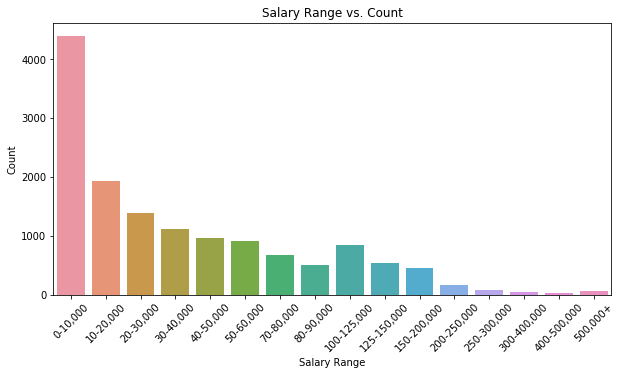

In [5]:
plt.figure(figsize=(10,5))
g = sns.countplot(x='Q9', data=data, order=['0-10,000', '10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','70-80,000','80-90,000','100-125,000','125-150,000','150-200,000','200-250,000','250-300,000','300-400,000','400-500,000','500,000+'])
g.set(xlabel='Salary Range', ylabel='Count')
plt.xticks(rotation=45)
plt.title("Salary Range vs. Count")

In [6]:
salary_count = data.Q9.value_counts(normalize=True)
salary_count

0-10,000       0.285048
10-20,000      0.125543
20-30,000      0.090414
30-40,000      0.072526
40-50,000      0.062545
50-60,000      0.059563
100-125,000    0.054637
60-70,000      0.047249
70-80,000      0.043878
90-100,000     0.036684
125-150,000    0.034545
80-90,000      0.032795
150-200,000    0.029620
200-250,000    0.011148
250-300,000    0.004861
500,000+       0.004083
300-400,000    0.003370
400-500,000    0.001491
Name: Q9, dtype: float64

To be more specific, approximately 30% of samples are in the 0-10,000 salary range while less than 3% earn salaries above 200,000. As a result, I have decided to group together all salaries above 200,000 in to one category called "200,000+" with the code below.

In [7]:
# remove categories less than a count of 180, which in this case are the salary ranges above 200,000
salary_count = data.Q9.value_counts()
value_mask = data.Q9.isin(salary_count.index[salary_count < 180]) 
data.loc[value_mask,'Q9'] = "200,000+"

#### Q1: Gender

The below graph shows the gender count from the dataset with the majority of surveyees identifying as males.

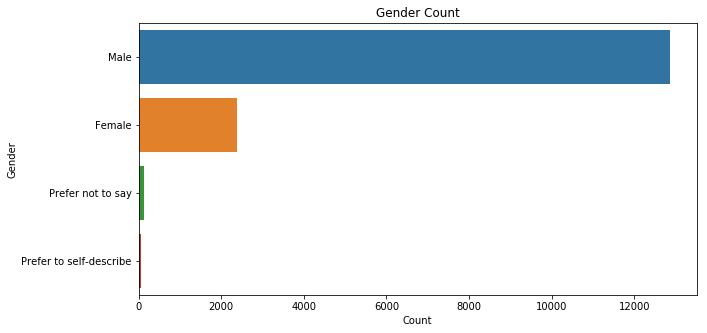

In [8]:
# plot the gender count
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q1', data=data)
g.set(xlabel='Count', ylabel='Gender')
_ = plt.xticks(rotation=0)
_ = plt.title("Gender Count")

Since the amount of entries for "Prefer not to say" and "Prefer to self-describe" are extremely low when compared to that of "Male" and "Female", I have decided to combine them in to one category called "Other".

In [9]:
_count = data.Q1.value_counts()
value_mask = data.Q1.isin(_count.index[_count < 150]) 
data.loc[value_mask,'Q1'] = "Other"

#### Q2: Age

From the plot below, the data features 12 age groups with most of the surveyees between the age of 25 and 29. To simplify the data, I have decided to create 5 new groups; namely, 18-24, 25-34, 35-44, 45-54, 55+ to incorporate a bigger range with each group. The intent here is to simplify the categories as well as provide more samples for the older population (above 55).

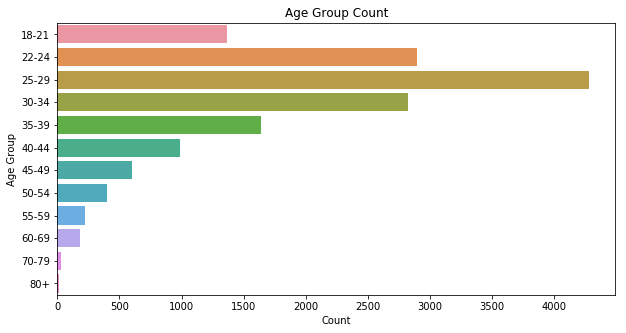

In [10]:
# plot the age count
_count = data.Q2.value_counts()
age_dict = _count.to_dict()
ordered = collections.OrderedDict(sorted(age_dict.items()))
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q2', data=data, order = ordered)
g.set(xlabel='Count', ylabel='Age Group')
_ = plt.xticks(rotation=0)
_ = plt.title("Age Group Count")

In [11]:
# Regroup different age ranges in to 5 groups
data['Q2'] = data['Q2'].replace('18-21', '18-24') #18-24
data['Q2'] = data['Q2'].replace('22-24', '18-24')
data['Q2'] = data['Q2'].replace('25-29', '25-34') #25-34
data['Q2'] = data['Q2'].replace('30-34', '25-34')
data['Q2'] = data['Q2'].replace('35-39', '35-44') #35-44
data['Q2'] = data['Q2'].replace('40-44', '35-44')
data['Q2'] = data['Q2'].replace('45-49', '45-54') #45-54
data['Q2'] = data['Q2'].replace('50-54', '45-54')
data['Q2'] = data['Q2'].replace('55-59', '55+') #55+
data['Q2'] = data['Q2'].replace('60-69', '55+')
data['Q2'] = data['Q2'].replace('70-79', '55+')
data['Q2'] = data['Q2'].replace('80+', '55+')

#### Q3: Country

The top 3 countries in the dataset are the United States of America, India and China. I have simplified the name of "United States of America" and "United Kingdom of Great Britain and Northern Ireland" in to their respective acronyms.

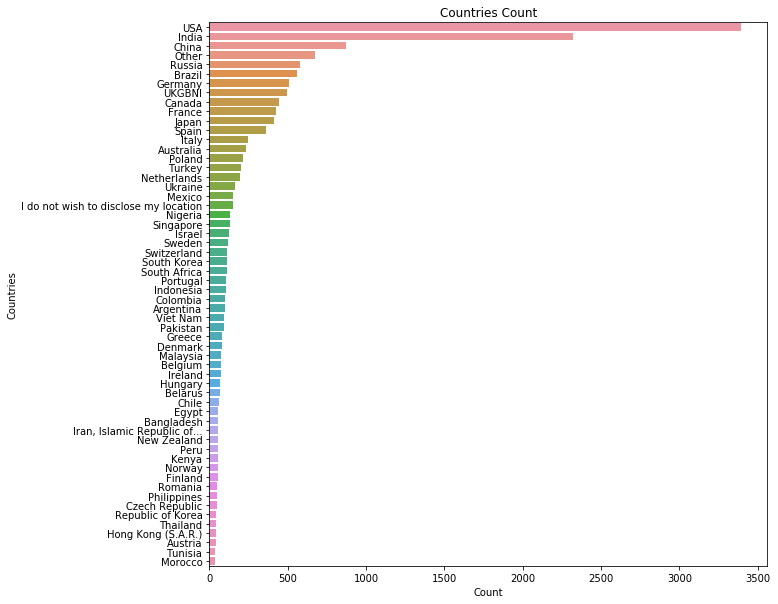

In [12]:
# Simplify Name
data['Q3'] = data['Q3'].replace('United States of America', 'USA')
data['Q3'] = data['Q3'].replace('United Kingdom of Great Britain and Northern Ireland', 'UKGBNI')
# plot Countries Count
_count = data.Q3.value_counts()
ordered = _count.index.tolist()
plt.figure(figsize=(10,10))
g = sns.countplot(y='Q3', data=data, order = ordered)
g.set(xlabel='Count', ylabel='Countries')
plt.xticks(rotation=0)
_=plt.title("Countries Count")

Since there are 58 countries with the majority accounting for less than 200 counts each, I have decided to combine these countries in to "Other". 

In [13]:
# removing countries with less than 200 counts
value_mask = data.Q3.isin(_count.index[_count < 200]) 
data.loc[value_mask,'Q3'] = "Other"
# Group together "I do not wish to disclose my location" with "Other"
data['Q3'] = data['Q3'].replace('I do not wish to disclose my location', 'Other')

#### Q4: Highest level of education 

There are 7 forms of education level according to the responses of this question which are listed below with their respective counts. From this, the majority of people who participated in this survey have either a Bachelor's, Master's or Doctoral degree. For the category of "Some college/university study without earning a bachelor’s degree" and "No formal education past high school", I have decided to rename it as "Non-conferred" and "Secondary School", respectively.

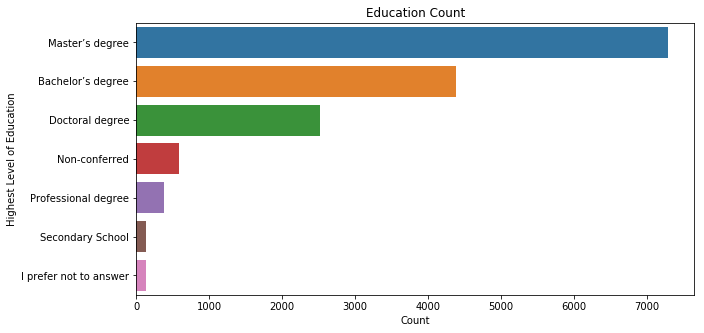

In [14]:
# Simplify category name
data['Q4'] = data['Q4'].replace('Some college/university study without earning a bachelor’s degree', 'Non-conferred')
data['Q4'] = data['Q4'].replace('No formal education past high school', 'Secondary School')
# plot Education Count
_count = data.Q4.value_counts()
ordered = _count.index.tolist()
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q4', data=data, order = ordered)
g.set(xlabel='Count', ylabel='Highest Level of Education')
plt.xticks(rotation=0)
_ = plt.title("Education Count")

In order to simplify this feature, I have decided to take a look at how each category compares with the target variable. In the code below, I label encoded the salary range and then plotted each of the education level against the salary. To label encode the salary, I used the function that was introduced at the beginning of the section called *cat_label*. I chose to label encode the salary because of its ordinal nature.

In [15]:
# label encode the salary ranges
Q9_order = ['0-10,000', '10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','60-70,000','70-80,000','80-90,000','90-100,000','100-125,000','125-150,000','150-200,000','200,000+']
Q9_label = cat_label('Q9', Q9_order)

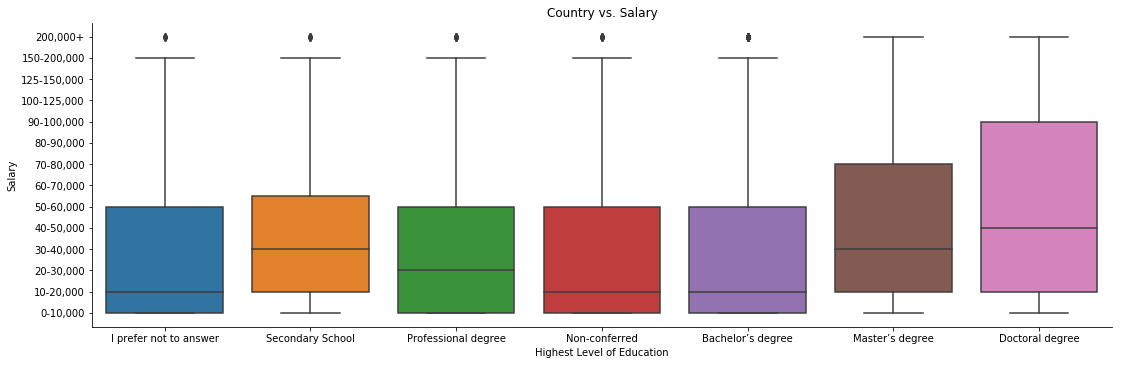

In [16]:
# plot the education level vs salary
g = sns.catplot(x='Q4', y='Q9_cat', data=data, order=['I prefer not to answer','Secondary School','Professional degree','Non-conferred','Bachelor’s degree','Master’s degree','Doctoral degree'],
            kind="box", height=5, aspect=3)
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Highest Level of Education", "Salary")
plt.title("Country vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

Since "Non-conferred", "I prefer not to answer" and "Bachelor's degree" all show similar salary earnings, I will combine these three categories in to "others" which brings the total amount of categories down to just 5 as seen in the plot below. Based on the result, it is interesting to see that those who only have a Secondary School degree earn more than those with professional degrees and Others (which include Bachelor's degree) while Doctoral degree holders earn the most.

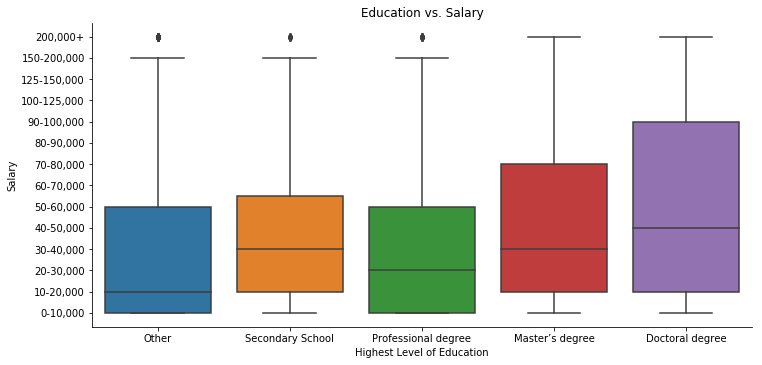

In [17]:
# combine 3 categories in to one
data['Q4'] = data['Q4'].replace('Non-conferred', 'Other')
data['Q4'] = data['Q4'].replace('I prefer not to answer', 'Other')
data['Q4'] = data['Q4'].replace('Bachelor’s degree', 'Other')
# plot education and salary again
g = sns.catplot(x='Q4', y='Q9_cat', data=data, order=['Other','Secondary School','Professional degree','Master’s degree','Doctoral degree'],
            kind="box", height=5, aspect=2)
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Highest Level of Education", "Salary")
plt.title("Education vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

#### Q5: Major in University/College

While looking at the raw data, I have decided to rename a few categories with a shorter form so that the plot would not be as cluttered. By looking at the data, most people who took part in this survey majored in software related programs (computer science, software engineering ... etc.). Other disciplines such as engineering, math and business are also prominant.

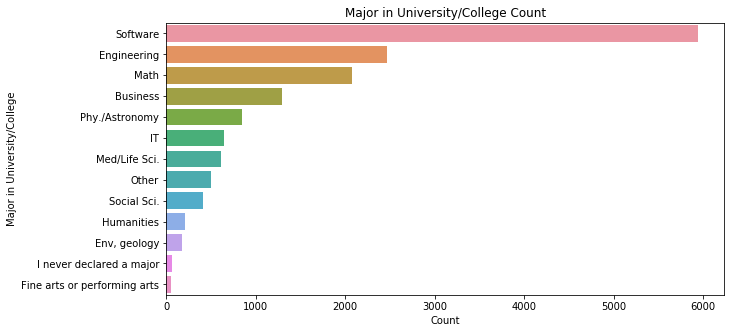

In [18]:
# Simplified naming
data['Q5'] = data['Q5'].replace('A business discipline (accounting, economics, finance, etc.)', 'Business')
data['Q5'] = data['Q5'].replace('Information technology, networking, or system administration', 'IT')
data['Q5'] = data['Q5'].replace('Medical or life sciences (biology, chemistry, medicine, etc.)', 'Med/Life Sci.')
data['Q5'] = data['Q5'].replace('Social sciences (anthropology, psychology, sociology, etc.)', 'Social Sci.')
data['Q5'] = data['Q5'].replace('Humanities (history, literature, philosophy, etc.)', 'Humanities')
data['Q5'] = data['Q5'].replace('Mathematics or statistics', 'Math')
data['Q5'] = data['Q5'].replace('Computer science (software engineering, etc.)', 'Software')
data['Q5'] = data['Q5'].replace('Engineering (non-computer focused)', 'Engineering')
data['Q5'] = data['Q5'].replace('Environmental science or geology', 'Env, geology')
data['Q5'] = data['Q5'].replace('Physics or astronomy', 'Phy./Astronomy')
# plot the major in university/college
major_count = data.Q5.value_counts()
ordered = major_count.index.tolist()
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q5', data=data, order = ordered)
g.set(xlabel='Count', ylabel='Major in University/College')
plt.xticks(rotation=0)
_=plt.title("Major in University/College Count")

To simplify this feature, I have decided to group together non-STEM (Science Technology Engineering Mathematics) disciplines together with "Others".

In [19]:
# Regroup
data['Q5'] = data['Q5'].replace('I never declared a major', 'Other')
data['Q5'] = data['Q5'].replace('Fine arts or performing arts', 'Other')
data['Q5'] = data['Q5'].replace('Humanities', 'Other')

#### Q6: Position Title

The following plot shows the different position titles of the surveyees with the top 3 being data scientists, students and software engineers.

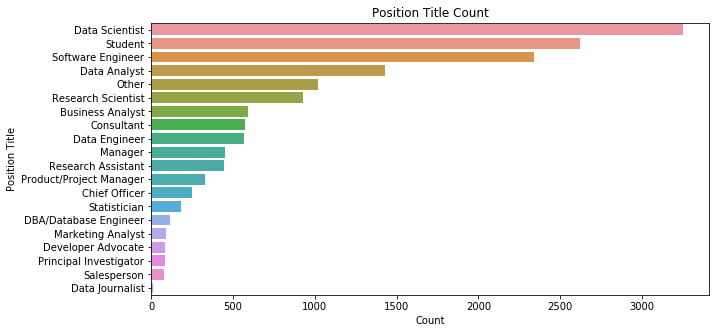

In [20]:
# plot the position title count
_count = data.Q6.value_counts()
ordered = _count.index.tolist()
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q6', data=data, order = ordered)
g.set(xlabel='Count', ylabel='Position Title')
plt.xticks(rotation=0)
_=plt.title("Position Title Count")

Similar to previous questions, I have eliminated position counts with less than 200. In addition, I have decided to group together Software Engineer and Data Engineer together to both be Software Engineer. I have also grouped all analyst, research and managerial positions in to "Analyst", "Researcher" and "Leader", respectively, since each of these roles share similar duties. For example, a "Chief Officer", "Manager" and "Project Manager" are all leadership positions.

In [21]:
value_mask = data.Q6.isin(_count.index[_count < 200]) 
data.loc[value_mask,'Q6'] = "Other"
data['Q6'] = data['Q6'].replace('Data Engineer', 'Software Engineer')
data['Q6'] = data['Q6'].replace('Data Analyst', 'Analyst')
data['Q6'] = data['Q6'].replace('Business Analyst', 'Analyst')
data['Q6'] = data['Q6'].replace('Research Scientist', 'Researcher')
data['Q6'] = data['Q6'].replace('Research Assistant', 'Researcher')
data['Q6'] = data['Q6'].replace('Research Assistant', 'Researcher')
data['Q6'] = data['Q6'].replace('Chief Officer', 'Leader')
data['Q6'] = data['Q6'].replace('Manager', 'Leader')
data['Q6'] = data['Q6'].replace('Product/Project Manager', 'Leader')

#### Q7: Industry

The top 4 industries that were included in this survey are the computers/technology, students, academia and accounting/finance.

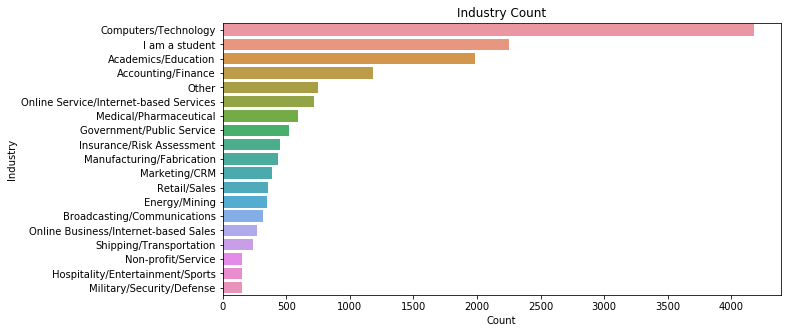

In [22]:
# plot the industry count
_count = data.Q7.value_counts()
ordered = _count.index.tolist()
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q7', data=data, order = ordered)
g.set(xlabel='Count', ylabel='Industry')
plt.xticks(rotation=0)
_ = plt.title("Industry Count")

I have removed all industry counts lower than 200 as well as renamed some the industry names into their shorter form. In addition, I have decided to combine "Online Service/Internet-based Services" and "Online Business/Internet-based Sales" to both be "online" as they are similar in nature.

In [23]:
value_mask = data.Q7.isin(_count.index[_count < 200]) 
data.loc[value_mask,'Q7'] = "Other"
data['Q7'] = data['Q7'].replace('Computers/Technology', 'Comp. Tech')
data['Q7'] = data['Q7'].replace('I am a student', 'Student')
data['Q7'] = data['Q7'].replace('Academics/Education', 'Academia')
data['Q7'] = data['Q7'].replace('Online Service/Internet-based Services', 'Online')
data['Q7'] = data['Q7'].replace('Online Business/Internet-based Sales', 'Online')
data['Q7'] = data['Q7'].replace('Broadcasting/Communications', 'Communication')

#### Q8: Years of Experience

In terms of years of experience, the most amount of data obtained are from surveyees with 0-1 years of experience. The data trend decreases from there all the way to 25-30 years with only a significant increase in count for the 5 to 10 years' range.

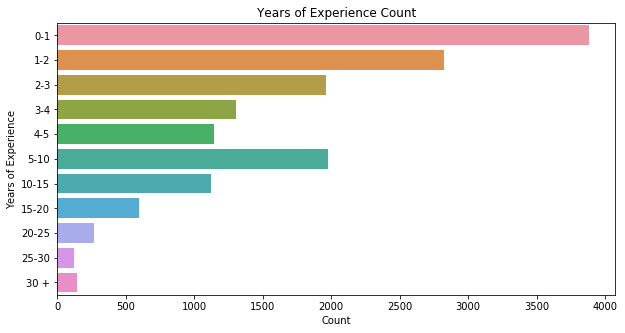

In [24]:
# plot years of experience count
yoe_count = data.Q8.value_counts()
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q8', data=data, order = ['0-1','1-2','2-3','3-4','4-5','5-10','10-15','15-20','20-25','25-30','30 +'])
g.set(xlabel='Count', ylabel='Years of Experience')
plt.xticks(rotation=0)
_=plt.title("Years of Experience Count")

To simplify the data, I have decided to create 3 groups to replace the original. These 3 groups are 0 to 5, 19 to 20 and 20+ with the 5 to 10 year range from the original untouched.

In [25]:
# Recategorize YOE
data['Q8'] = data['Q8'].replace('0-1', '0-5') # 0-5 years
data['Q8'] = data['Q8'].replace('1-2', '0-5')
data['Q8'] = data['Q8'].replace('2-3', '0-5')
data['Q8'] = data['Q8'].replace('3-4', '0-5')
data['Q8'] = data['Q8'].replace('4-5', '0-5')
data['Q8'] = data['Q8'].replace('10-15', '10-20')# 10-20
data['Q8'] = data['Q8'].replace('15-20', '10-20')
data['Q8'] = data['Q8'].replace('20-25', '20+') # 20+
data['Q8'] = data['Q8'].replace('25-30', '20+')
data['Q8'] = data['Q8'].replace('30 +', '20+')

#### Q24: How long have you been writing code to analyze data

Similar to the years of experience, the majority of the data are from people with low experience. In this case, 0 to 5 years makes up for the majority of the data; as a result I have decided to create new ranges. The first one is 0-5 years which include the people that have never written code (whether they intend to learn or not is treated the same). In addition, I have combined all ranges above 10 years together because they all have really low counts.

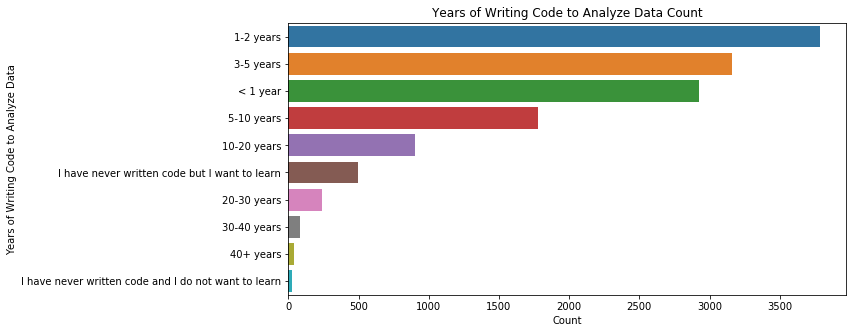

In [26]:
# plot years of writing code to analyze data
_count = data['Q24'].value_counts()
ordered = _count.index.tolist()
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q24', data=data, order = ordered)
g.set(xlabel='Count', ylabel='Years of Writing Code to Analyze Data')
plt.xticks(rotation=0)
_=plt.title("Years of Writing Code to Analyze Data Count")

In [27]:
# regroup categories
data['Q24'] = data['Q24'].replace('< 1 year', '0-5') # 0-5 years
data['Q24'] = data['Q24'].replace('1-2 years', '0-5')
data['Q24'] = data['Q24'].replace('3-5 years', '0-5')
data['Q24'] = data['Q24'].replace('I have never written code but I want to learn', '0-5')
data['Q24'] = data['Q24'].replace('I have never written code and I do not want to learn', '0-5')
data['Q24'] = data['Q24'].replace('5-10 years', '5-10') # 5-10 years
data['Q24'] = data['Q24'].replace('10-20 years', '10+') # 10+ years
data['Q24'] = data['Q24'].replace('20-30 years', '10+')
data['Q24'] = data['Q24'].replace('30-40 years', '10+')
data['Q24'] = data['Q24'].replace('40+ years', '10+')

#### Q25: Years of ML Experience

Based on the plot below, the majority of the surveyees have low years of experience with machine learning. This is understandable as this is an up and coming field.

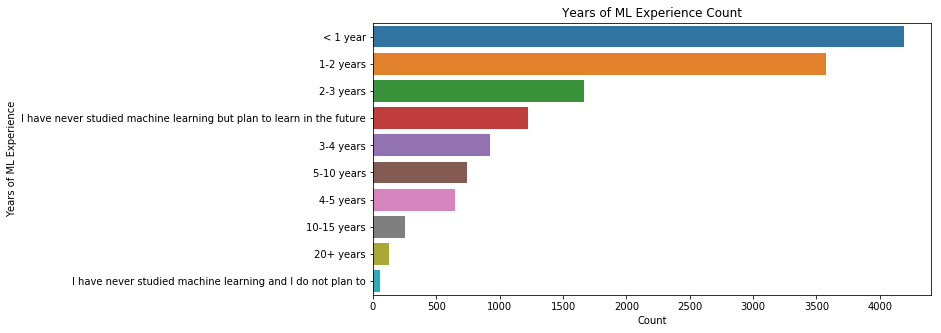

In [28]:
_count = data['Q25'].value_counts()
ordered = _count.index.tolist()
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q25', data=data, order = ordered)
g.set(xlabel='Count', ylabel='Years of ML Experience')
plt.xticks(rotation=0)
_=plt.title("Years of ML Experience Count")

Since roughly 70% of the samples have less than 5 years of experience, I have decided to create two separate categories; one for those with lower than 5 and another for those with higher than 5 years of experience.

In [29]:
data.Q25.value_counts(normalize=True)

< 1 year                                                                 0.312635
1-2 years                                                                0.266418
2-3 years                                                                0.124040
I have never studied machine learning but plan to learn in the future    0.091316
3-4 years                                                                0.068654
5-10 years                                                               0.055386
4-5 years                                                                0.048453
10-15 years                                                              0.019083
20+ years                                                                0.009616
I have never studied machine learning and I do not plan to               0.004398
Name: Q25, dtype: float64

In [30]:
# regroup categories
data['Q25'] = data['Q25'].replace('< 1 year', '0-5') # 0-5
data['Q25'] = data['Q25'].replace('1-2 years', '0-5')
data['Q25'] = data['Q25'].replace('2-3 years', '0-5')
data['Q25'] = data['Q25'].replace('I have never studied machine learning but plan to learn in the future', '0-5')
data['Q25'] = data['Q25'].replace('I have never studied machine learning and I do not plan to', '0-5')
data['Q25'] = data['Q25'].replace('3-4 years', '0-5')
data['Q25'] = data['Q25'].replace('4-5 years', '0-5')
data['Q25'] = data['Q25'].replace('5-10 years', '5+') # 5+
data['Q25'] = data['Q25'].replace('10-15 years', '5+')
data['Q25'] = data['Q25'].replace('20+ years', '5+')

#### Q26: Do you consider yourself to be a data scientist?

It seems that the majority of surveyees consider themselves to be either "probably" or "definitely" a data scientist. To simplify the data, I grouped together "probably yes" and "definitely yes" to just "yes" and "probably not" and "definitely not" to just "no". The idea is that if someone chose probably yes instead of maybe, then they are leaning more towards yes than they are to no.

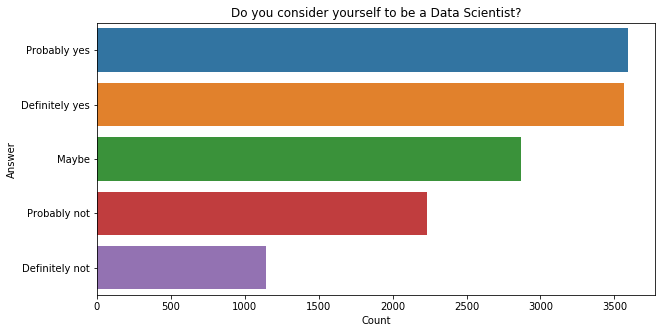

In [31]:
_count = data['Q26'].value_counts()
ordered = _count.index.tolist()
plt.figure(figsize=(10,5))
g = sns.countplot(y='Q26', data=data, order = ordered)
g.set(xlabel='Count', ylabel='Answer')
plt.xticks(rotation=0)
_=plt.title("Do you consider yourself to be a Data Scientist?")

In [32]:
# regroup data
data['Q26'] = data['Q26'].replace('Probably yes', 'Yes')
data['Q26'] = data['Q26'].replace('Probably not', 'No')
data['Q26'] = data['Q26'].replace('Definitely yes', 'Yes')
data['Q26'] = data['Q26'].replace('Definitely not', 'No')

### 1.2 Encode Features

Since machine learning algorithms only accept numeric values, categorical values must be converted to numbers. In this section, the features are converted to numeric values.

#### Feature Encoding Functions 

I have created two classes of functions below. The first class features a function that is able to combine the specified columns by taking the summation at each cell. The second class features functions that fill individual cells in the dataframe. More specifically, the *nan_text* function fills NaN values with either a zero or a one. The *col2num* function fills NaN values with zero and then convert them to floats. 

In practicality, only the last function (*encode_col*) is most used to encode features that are spread out over many parts (columns). For example, in the feature below, Q11 asks the surveyee which activity makes up an important part of their role at work. Over the next 7 columns show the responses that each surveyee chose. In this case, I can one hot encode all cells with a text entry as 1 and empty cells as zero in each column. As a result of this, I should have as many columns as there are parts in a particular question, with either zeros or ones in each column. Later on in Section 3.1, I will combine certain features across its columns to generate a sum of how many entries were selected per question, per surveyee (more details on this later). The functions defined below will be used throughout the assignment.

In [33]:
Q11_dataframe = data.filter(['Q11_Part_1','Q11_Part_2','Q11_Part_3','Q11_Part_4','Q11_Part_5','Q11_Part_6','Q11_Part_7'], axis=1)
Q11_dataframe.head(10)

,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7
1,NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN
2,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,Other
4,NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN
5,NaN,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,NaN
6,NaN,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,NaN,NaN,NaN,NaN
7,NaN,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,NaN,NaN
9,Analyze and understand data to influence produ...,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,NaN,NaN
10,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# this class combines columns together to a single column
class combine_col:
    # Function to concatenate multiple columns of num in to one single column (by addition)
    def sum_int(col_name, start, end):
        one = data[col_name+'_Part_'+str(start)]
        two = data[col_name+'_Part_'+str(start+1)]
        col_combined = one+two
        # iterate from start to end
        for i in range(start+2, end+1):
            next_col = data[col_name+'_Part_'+str(i)]
            col_combined = col_combined+next_col
        # if the sum of specified columns equal to zero, this row was originally a NaN
        col_combined = col_combined.replace(0, np.nan)
        # if the sum of specified columns is above 100, this row was originally a "None" and should be zero
        col_combined[col_combined > 99] = 0
        return col_combined
# this class is for filling cells with information
class fill_info:
    # this function converts NaN values to texts
    def nan_text(col_name,start, end, none_col):
        for i in range (start, end+1): # it first converts NaN's to zeros
            data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].fillna(0)
        # Before converting all texts to 1, save a list of the categories
        features_list = list()
        for i in range (start, end+1): # save features to a list
            spot = data[col_name+'_Part_'+str(i)].ne(0).idxmax()
            feature = data[col_name+'_Part_'+str(i)].iloc[spot-1]
            features_list.append(feature)
        for i in range (start, end+1): # convert cells with texts in to "1"
            if i == none_col: # Some features have a column that signifies "none", these should be set to zero instead of one
                data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].astype(bool).astype(int)
                data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].replace(1, 100)
            else: # otherwise set the text cell to 1
                data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].astype(bool).astype(int)
        return features_list
    # this function converts the specified columns to a number
    def col2num(col_name, start, end):
        for i in range (start, end+1): #fill nan with zero
            data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].fillna(0)
        for i in range (start, end+1): # convert everything to type float
            data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].astype(float)
# encode columns with numbers
def encode_col(col_name, start, end, none_col):
    features = fill_info.nan_text(col_name, start, end, none_col)
    combined = combine_col.sum_int(col_name, start, end)
    return features, combined


#### Encode categorical data

In [35]:
# these two Q's are percentage based
fill_info.col2num('Q34', 1, 6)# Q34
Q34_combined = combine_col.sum_int('Q34',1,6)
fill_info.col2num('Q35', 1, 6)# Q35
Q35_combined = combine_col.sum_int('Q35',1,6)

In [36]:
# encode multi-part features as mentioned previously
# there are 4 arguments to the functions, the first argument is the column of interest, 
# then the starting column, finish column and lastly the column with the "None" value
Q11_features, Q11_combined = encode_col('Q11', 1, 7, 0)
Q13_features, Q13_combined = encode_col('Q13', 1, 15, 14)
Q14_features, Q14_combined = encode_col('Q14', 1, 11, 10)
Q15_features, Q15_combined = encode_col('Q15', 1, 7, 6)
Q16_features, Q16_combined = encode_col('Q16', 1, 18, 0)
Q19_features, Q19_combined = encode_col('Q19', 1, 19, 18)
Q21_features, Q21_combined = encode_col('Q21', 1, 13, 12)
Q27_features, Q27_combined = encode_col('Q27', 1, 20, 0)
Q28_features, Q28_combined = encode_col('Q28', 1, 43, 0)
Q29_features, Q29_combined = encode_col('Q29', 1, 28, 0)
Q30_features, Q30_combined = encode_col('Q30', 1, 25, 0)
Q31_features, Q31_combined = encode_col('Q31', 1, 12, 0)
Q33_features, Q33_combined = encode_col('Q33', 1, 11, 10)
Q36_features, Q36_combined = encode_col('Q36', 1, 13, 0)
Q38_features, Q38_combined = encode_col('Q38', 1, 22, 0)
Q42_features, Q42_combined = encode_col('Q42', 1, 5, 0)
Q44_features, Q44_combined = encode_col('Q44', 1, 6, 0)
Q45_features, Q45_combined = encode_col('Q45', 1, 6, 0)
Q47_features, Q47_combined = encode_col('Q47', 1, 16, 0)
Q49_features, Q49_combined = encode_col('Q49', 1, 12, 0)
Q50_features, Q50_combined = encode_col('Q50', 1, 8, 0)

### 1.3 Missing Values

In this section, the missing values in the dataframe are handled.

#### Functions to deal with NaN values

In [37]:
# calculate percentage of NaN values in a column (feature)
def col_nan_percent(dataframe):
    total_col = encoded_all.shape[0]
    for (columnName, columnData) in dataframe.iteritems():
        missing = dataframe[columnName].isna().sum()
        missing_percentage = round((missing/total_col)*100, 2)
        print(str(columnName) + ': ' + str(missing_percentage) +' %')
# calculate percentage of NaN values in a row (sample)
def row_nan_percent(dataframe):
    total_row = dataframe.shape[1]
    for (rowName, rowData) in dataframe.iterrows():
        missing = dataframe.loc[rowName].isna().sum()
        missing_percentage = round((missing/total_row)*100, 2)
        print(str(rowName) + ': ' + str(missing_percentage) +' %')
# drop columns with more than threshold data missing, returns the new dataframe
def drop_col(dataframe, threshold):
    total_col = encoded_all.shape[0]
    for (columnName, columnData) in dataframe.iteritems():
        missing = dataframe[columnName].isna().sum()
        missing_percentage = round((missing/total_col)*100, 2)
        if missing_percentage > threshold:
            # drops the column from the dataframe
            dataframe = dataframe.drop([columnName], axis=1)
            # drops equivalent columns in the og dataframe (Data) including all its parts
            data.drop([col for col in data.columns if columnName in col],axis=1,inplace=True)
    return dataframe
# drop rows with more than threshold data missing, returns the new dataframe as well as the row index
def drop_row(dataframe, threshold):
    row_index = []
    total_row = dataframe.shape[1]
    for (rowName, rowData) in dataframe.iterrows():
        missing = dataframe.loc[rowName].isna().sum()
        missing_percentage = round((missing/total_row)*100, 2)
        if missing_percentage > threshold:
            dataframe = dataframe.drop(rowName)
            row_index.append(rowName)
            data.drop(rowName, inplace = True)
    return dataframe, row_index

Firstly, I concatenate the previously encoded data together to form an *encoded_all* dataset which features all the data in a partially encoded form. The reason this is only a partially encoded form is that some data still needs to be one hot or label encoded (will be completed after the data is fully cleaned); however, for the sake of dealing with missing values, it is easier to do it without the data being fully encoded so that finding relationships between features is still possible. 

In addition, questions with multiple parts are combined in to one column so that it is easier to differentiate between actual missing values, or if the user selected a different answer within the same feature. For example, in Q31 there are 12 parts. In each part, you are to specify which types of data you interact with most. If you have only interacted with 1 of the 12 choices provided, your sample will have 11 columns of NaN values and the last column with the single 1 choice you selected. Without taking a summation of the 12 columns, one may be quick to conclude that 11 of the 12 columns are holding missing values and hence those features are uselss. To avoid this problem, I take the sum across the columns, and only if the summation is zero will this entry be considered as a NaN. Furthermore, since the multi-part questions always have a choice of "None" (or something with the same meaning), the summation of columns could give an answer of 1, implying the user has at least one of the many skills provided. This is wrong because this value should actually be zero. To solve this problem, an *if-statement* was implemented in the functions declared in section 1.2 to mitigate this issue.

With this dataset, I plotted the heatmap below where the red implies missing values. From this, it is evident that features from Q1 to Q10 do not have many missing values while others such as Q27-Q30, Q32, Q37 do. Looking at it from a sample perspective, it seems that surveyees who tend to skip questions does so consistently after the 10th question as shown by the horizontal streaks of red. In other words, those who chose to skip questions early in the survey does so continuously to the end.

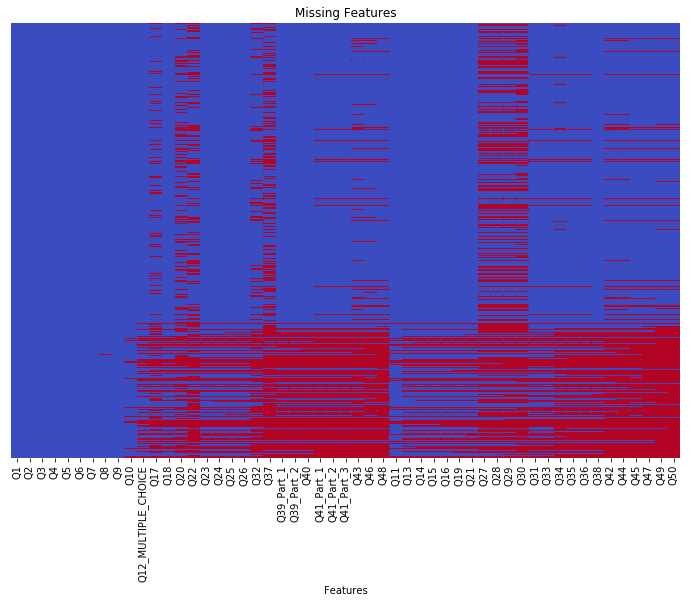

In [38]:
# new data frame with all the combined columns
cat_encoded = pd.concat([Q11_combined, Q13_combined, Q14_combined, Q15_combined, Q16_combined, Q19_combined, Q21_combined, Q27_combined, Q28_combined, Q29_combined, Q30_combined, Q31_combined, Q33_combined, Q34_combined, Q35_combined, Q36_combined, Q38_combined, Q42_combined, Q44_combined, Q45_combined, Q47_combined, Q49_combined, Q50_combined],axis=1)
cat_encoded.columns = ['Q11','Q13','Q14','Q15','Q16','Q19','Q21','Q27','Q28','Q29','Q30','Q31','Q33','Q34','Q35','Q36','Q38','Q42','Q44','Q45','Q47','Q49','Q50']
# new data frame with all the ones that were made dummy
dummy_encoded = pd.concat([data['Q1'],data['Q2'],data['Q3'],data['Q4'],data['Q5'],data['Q6'],data['Q7'],data['Q8'],data['Q9'],data['Q10'],data['Q12_MULTIPLE_CHOICE'],data['Q17'],data['Q18'],data['Q20'],data['Q22'],data['Q23'],data['Q24'],data['Q25'],data['Q26'],data['Q32'],data['Q37'],data['Q39_Part_1'],data['Q39_Part_2'],data['Q40'],data['Q41_Part_1'],data['Q41_Part_2'],data['Q41_Part_3'],data['Q43'],data['Q46'],data['Q48']], axis=1)
# Check missing values from the whole encoded data set
encoded_all = pd.concat([dummy_encoded, cat_encoded], axis=1)
# plot nan
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(encoded_all.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
_=plt.title('Missing Features')
_=plt.xlabel('Features')

### 1.3.1 Removing Missing Values

To deal with the missing values, I have decided to first remove features with more than 20% missing data. After that, I remove surveyees who did not answer more than 20% of the questions. This leaves a dataset as seen below where the amount of features have reduced from 53 down to 25.

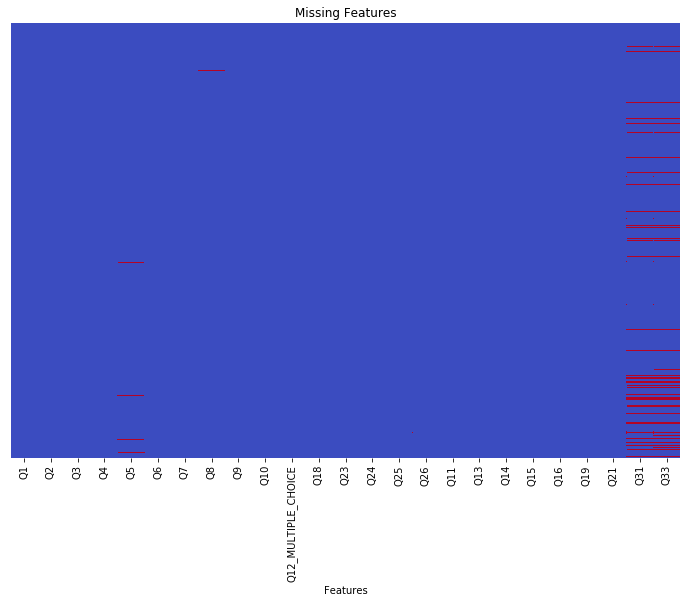

In [39]:
# first drop columns(features) that have more than 20% missing data
encoded_col_dropped = drop_col(encoded_all, 20)
# then drop entries with more than 20% missing data
encoded_dropped, row_index = drop_row(encoded_col_dropped, 20)
# plot
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(encoded_dropped.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
plt.title('Missing Features')
_=plt.xlabel('Features')

### 1.3.2 Filling Missing Values

Within the 25 features that remain, there are 7 questions that still have missing values. As a result, this section will explore the rest of the data to find ways to fill in the missing information.

In [40]:
encoded_dropped.isnull().sum()

Q1                        0
Q2                        0
Q3                        0
Q4                        0
Q5                       89
Q6                        0
Q7                        0
Q8                       62
Q9                        0
Q10                       0
Q12_MULTIPLE_CHOICE       0
Q18                       0
Q23                       0
Q24                      20
Q25                      46
Q26                      55
Q11                       0
Q13                       0
Q14                       0
Q15                       0
Q16                       0
Q19                       0
Q21                       0
Q31                    1043
Q33                    1117
dtype: int64

#### Q5: Undergraduate/College Major

Starting with Q5 which is regarding the undergraduate/college major. Based on the data, it seems that 100% of the people who did not answer this question have only completed secondary school. As a result, I have decided to fill all the missing values here with a new category called "Secondary School Only"

In [41]:
Q5_missing = encoded_dropped[encoded_dropped['Q5'].isnull()]
Q5_missing.Q4.value_counts(normalize=True)

Secondary School    1.0
Name: Q4, dtype: float64

In [42]:
# fill those nan values with a new category
data['Q5'] = data['Q5'].fillna('Secondary School Only')

#### Q8: How many years of experience in current role?

Q8 is regarding the years of experience in the current role. Based on the missing values, 85% of people who did not answer are currently students.

In [43]:
Q8_missing = encoded_dropped[encoded_dropped['Q8'].isnull()]
Q8_missing.Q6.value_counts(normalize=True)

Student           0.854839
Analyst           0.096774
Data Scientist    0.016129
Researcher        0.016129
Consultant        0.016129
Name: Q6, dtype: float64

Furthermore, 90% of people who did not answer are under 35 years of age

In [44]:
Q8_missing.Q2.value_counts(normalize=True)

18-24    0.661290
25-34    0.290323
45-54    0.032258
35-44    0.016129
Name: Q2, dtype: float64

To combine the two previously mentioned, approximately 86% of students who are also under the age of 35 chose "0-5 years" for their duration of experience. As a result, I will fill the missing values with "0-5".

In [45]:
under_thirty = data.loc[data['Q2'].isin(['18-24','25-34'])]
students_under_thirty = under_thirty.loc[data['Q6'].isin(['Student'])]
students_under_thirty.Q8.value_counts(normalize=True)

0-5      0.862755
10-20    0.082242
5-10     0.049240
20+      0.005762
Name: Q8, dtype: float64

In [46]:
# fill those nan values with 0-5 YOE
data['Q8'] = data['Q8'].fillna('0-5')

#### Q24: How long have you been writing code to analyze data

Since the mode of this question is 0-5, I will fill the missing values accordingly.

In [47]:
# since the mode is 0-5 years
data.Q24.mode()

0    0-5
dtype: object

In [48]:
# fill nan values
data['Q24'] = data['Q24'].fillna('0-5')

#### Q25: How many years have you used ML methods?

For this question, it seems that only 9% of people who did not answer are students which implies that the remaining 90% are working (employed).

In [49]:
Q25_missing = encoded_dropped[encoded_dropped['Q25'].isnull()]
Q25_missing.Q6.value_counts(normalize=True)

Data Scientist       0.217391
Software Engineer    0.217391
Analyst              0.130435
Other                0.130435
Researcher           0.086957
Student              0.086957
Leader               0.065217
Consultant           0.065217
Name: Q6, dtype: float64

Based on this evidence, it seems that 65% of current employers of those who did not answer Q25 are *not well established in ML methods*. This implies that employees who work for companies that are *not well established in ML* likely did not answer their years of experience with ML.

In [50]:
Q25_missing.Q10.value_counts(normalize=True)

We are exploring ML methods (and may one day put a model into production)                    0.282609
No (we do not use ML methods)                                                                0.217391
We have well established ML methods (i.e., models in production for more than 2 years)       0.173913
We recently started using ML methods (i.e., models in production for less than 2 years)      0.152174
I do not know                                                                                0.108696
We use ML methods for generating insights (but do not put working models into production)    0.065217
Name: Q10, dtype: float64

Using this, I looked at what employees who work for companies not familiar with ML usually list for their years of experience with ML in this survey. It turns out that 95% of them chose 0-5 years; therefore, I will fill the missing values with 0-5 years of experience.

In [51]:
not_familiar = data.loc[data['Q10'].isin(['We are exploring ML methods (and may one day put a model into production)','No (we do not use ML methods)', 'We recently started using ML methods (i.e., models in production for less than 2 years)'])]

not_familiar.Q25.value_counts(normalize=True)

0-5    0.94566
5+     0.05434
Name: Q25, dtype: float64

In [52]:
# fill those nan values with 0-5 years of ML experience
data['Q25'] = data['Q25'].fillna('0-5')

#### Q26: Do you consider yourself to be a data scientist?

It seems that the people who did not answer whether they consider themselves to be data scientists are roughly split between software engineers, analysts and data scientists.

In [53]:
Q26_missing = encoded_dropped[encoded_dropped['Q26'].isnull()]
Q26_missing.Q6.value_counts(normalize=True)

Analyst              0.200000
Software Engineer    0.200000
Data Scientist       0.181818
Other                0.127273
Student              0.090909
Researcher           0.072727
Leader               0.072727
Consultant           0.054545
Name: Q6, dtype: float64

Based on the data, roughly 90% of people who have the job title of a data scientist considers themselves to be data scientists.

In [54]:
DS_title = data.loc[data['Q6'].isin(['Data Scientist'])]
DS_title['Q26'].value_counts(normalize=True)

Yes      0.891086
Maybe    0.089477
No       0.019437
Name: Q26, dtype: float64

Interestingly, the mode of the people who are not data scientists also considers themselves to be data scientists.

In [55]:
NotDS_title = data.loc[~data['Q6'].isin(['Data Scientist'])]
# the mode of people who are not data scientists have also consider themselves as data scientists
NotDS_title['Q26'].mode()

0    Yes
dtype: object

Furthermore, only 25% of people in the dataset are certain that they are not data scientists. As a result, since most data scientists and the mode of those who are not data scientists all considers themselves to be data sicentists, and that only 25% of the population are sure they are not; therefore, I will fill the missing information with "yes".

In [56]:
# only 25% people are certain they are not data scientists
data['Q26'].value_counts(normalize=True)

Yes      0.534164
No       0.251828
Maybe    0.214009
Name: Q26, dtype: float64

In [57]:
# fill those nan values yes
data['Q26'] = data['Q26'].fillna('Yes')

#### Q31: Which type of data do you currently interact with most often at work?

The following shows the percentage of different data types that survyees chose. From the results, it is apparent that over 90% of people have worked with audio, genetic, video and other types of data. As a result, I will fill the missing values with these 4 data types.

In [58]:
# get the percentage of each part
Q31P1 = data['Q31_Part_1'].value_counts(normalize=True).tolist()
Q31P2 = data['Q31_Part_2'].value_counts(normalize=True).tolist()
Q31P3 = data['Q31_Part_3'].value_counts(normalize=True).tolist()
Q31P4 = data['Q31_Part_4'].value_counts(normalize=True).tolist()
Q31P5 = data['Q31_Part_5'].value_counts(normalize=True).tolist()
Q31P6 = data['Q31_Part_6'].value_counts(normalize=True).tolist()
Q31P7 = data['Q31_Part_7'].value_counts(normalize=True).tolist()
Q31P8 = data['Q31_Part_8'].value_counts(normalize=True).tolist()
Q31P9 = data['Q31_Part_9'].value_counts(normalize=True).tolist()
Q31P10 = data['Q31_Part_10'].value_counts(normalize=True).tolist()
Q31P11 = data['Q31_Part_11'].value_counts(normalize=True).tolist()
Q31P12 = data['Q31_Part_12'].value_counts(normalize=True).tolist()
# Create a dictionary with the percentage of people working with each kinds of data
dict_Q31 = {'Audio:': Q31P1[0], 'Categorical:': Q31P2[0], 'Genetic:':Q31P3[0], 'Geospatial:':Q31P4[0], 'Image:':Q31P5[0], 'Numerical':Q31P6[0], 'Sensor:':Q31P7[0], 'Tabular:':Q31P8[0], 'Text:':Q31P9[0], 'Time:':Q31P10[0],'Video:':Q31P11[0],'Other:':Q31P12[0]}
# Audio (1), Genetic (3), Other(12) and Video(11) all have above 90%
dict_Q31

{'Audio:': 0.9500780031201248,
 'Categorical:': 0.5420845405244781,
 'Genetic:': 0.9414605155634796,
 'Geospatial:': 0.8676918505311642,
 'Image:': 0.7214917168115296,
 'Numerical': 0.6092415125176436,
 'Other:': 0.9778619716217221,
 'Sensor:': 0.8592972290320184,
 'Tabular:': 0.5812346779585469,
 'Text:': 0.5208379763761979,
 'Time:': 0.5560508134611098,
 'Video:': 0.9271970878835153}

In [59]:
%%time
# fill Part 1, Part 3, Part 7 and Part 12 with 1 for the NaN values
Q31_nan_row_index = Q31_combined.index[Q31_combined.isna()].tolist()
iteration = 1
for i in Q31_nan_row_index:
    data['Q31_Part_1'].loc[i]=1
    data['Q31_Part_3'].loc[i]=1
    data['Q31_Part_11'].loc[i]=1
    data['Q31_Part_12'].loc[i]=1
    percent_complete = round((iteration/len(Q31_nan_row_index))*100,2)
    clear_output(wait=True)
    iteration = iteration + 1
    print('Complete: ' + str(percent_complete) + '%')

Complete: 100.0%
CPU times: user 32.8 s, sys: 779 ms, total: 33.5 s
Wall time: 32.3 s


#### Q33: Where do you find public data sets

Like the previous question, it seems that more than 90% of surveyees chose "other" for where they find public datasets. As a result, I will fill the missing values with "other".

In [60]:
# get the percentage of each part
Q33P1 = data['Q33_Part_1'].value_counts(normalize=True).tolist()
Q33P2 = data['Q33_Part_2'].value_counts(normalize=True).tolist()
Q33P3 = data['Q33_Part_3'].value_counts(normalize=True).tolist()
Q33P4 = data['Q33_Part_4'].value_counts(normalize=True).tolist()
Q33P5 = data['Q33_Part_5'].value_counts(normalize=True).tolist()
Q33P6 = data['Q33_Part_6'].value_counts(normalize=True).tolist()
Q33P7 = data['Q33_Part_7'].value_counts(normalize=True).tolist()
Q33P8 = data['Q33_Part_8'].value_counts(normalize=True).tolist()
Q33P9 = data['Q33_Part_9'].value_counts(normalize=True).tolist()
Q33P10 = data['Q33_Part_10'].value_counts(normalize=True).tolist()
Q33P11 = data['Q33_Part_11'].value_counts(normalize=True).tolist()
# Create a dictionary with the percentage of people working with each kinds of data
dict_Q33 = {'Government:': Q33P1[0], 'University Research:': Q33P2[0], 'Non Profit Research:':Q33P3[0], 'Dataset Aggregator:':Q33P4[0], 'Own:':Q33P5[0], 'Public Release from Private Company':Q33P6[0], 'Google Search:':Q33P7[0], 'Google Dataset Search:':Q33P8[0], 'GitHub:':Q33P9[0], 'None:':Q33P10[0],'Other:':Q31P11[0]}
# Other(8) have above 90%
dict_Q33

{'Dataset Aggregator:': 0.564668301017755,
 'GitHub:': 0.6771413713691404,
 'Google Dataset Search:': 0.8066265507763167,
 'Google Search:': 0.6181561548176213,
 'Government:': 0.7292920288240101,
 'Non Profit Research:': 0.845999554267885,
 'None:': 0.8806180818661318,
 'Other:': 0.9271970878835153,
 'Own:': 0.7035881435257411,
 'Public Release from Private Company': 0.8318104152737538,
 'University Research:': 0.7753510140405616}

In [61]:
%%time
Q33_nan_row_index = Q33_combined.index[Q33_combined.isna()].tolist()
iteration = 1
for i in Q33_nan_row_index:
    data['Q33_Part_11'].loc[i]=1
    percent_complete = round((iteration/len(Q33_nan_row_index))*100,2)
    clear_output(wait=True)
    iteration = iteration + 1
    print('Complete: ' + str(percent_complete) + '%')

Complete: 100.0%
CPU times: user 11.5 s, sys: 546 ms, total: 12 s
Wall time: 11 s


### 1.4 Complete Cleaned Data

Now that the missing values are filled, I can create a complete cleaned dataset. In order to do so, I created the following function to create dummy columns for one hot encoding.

In [62]:
# creates dummy columns (one hot encoding)
def dummy(col_name):
    global data
    dummy = pd.get_dummies(data[col_name], prefix=col_name)
    return dummy

I then finish encoding all the data using either label encoding or one hot encoding. For features such as Q2, Q8, Q24 and Q25, I decided to *label encode* them since there is an ordinal relationship within these features. These relationships are mostly related with years. For example, in Q2, the age group of 18-24 should be labelled as 1, while the subsequent age group 25-34 should be labelled as 2 and so on. This kind of labelling was also done earlier in this assignment for the salary. For non-ordinal data, I simply just one hot encoded the feature.

In [63]:
# encoding features
Q1_dummies = dummy('Q1')
Q2_order = ['18-24','25-34','35-44','45-54','55+']
Q2_label = cat_label('Q2',Q2_order)
Q3_dummies = dummy('Q3')
Q4_dummies = dummy('Q4')
Q5_dummies = dummy('Q5')
Q6_dummies = dummy('Q6')
Q7_dummies = dummy('Q7')
Q8_order = ['0-5','5-10','10-20','20+']
Q8_label = cat_label('Q8', Q8_order)
Q10_dummies = dummy('Q10')
Q12_dummies = dummy('Q12_MULTIPLE_CHOICE')
Q18_dummies = dummy('Q18')
Q23_dummies = dummy('Q23')
Q24_order = ['0-5','5-10','10+']
Q24_label = cat_label('Q24', Q24_order)
Q25_order = ['0-5', '5+']
Q25_label = cat_label('Q25', Q25_order)
Q26_dummies = dummy('Q26')

I then form the complete dataset that is ready for the logistic regression alogorithm. In addition, I also make sure that the target variable is moved to the last column.

In [64]:
# concatenate all dummy data
dummy_data = pd.concat([Q1_dummies, Q3_dummies, Q4_dummies, Q5_dummies, Q6_dummies, Q7_dummies, Q10_dummies, Q12_dummies, Q18_dummies, Q23_dummies, Q26_dummies], axis=1)
# drop any column with "TEXT" in title
data.drop([col for col in data.columns if 'TEXT' in col],axis=1,inplace=True)
# drop other unecessary columns
data.drop(['Unnamed: 0', 'Time from Start to Finish (seconds)', 'index'], axis=1, inplace=True)
# form cleaned data
cleaned_data = pd.concat([dummy_data, data], axis=1)
cleaned_data.drop(['Q9','Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q10','Q12_MULTIPLE_CHOICE','Q18','Q23','Q24','Q25','Q26'], axis=1, inplace=True)
# move salary label to the last column
cols_ = list(cleaned_data.columns.values)
cols_.pop(cols_.index('Q9_cat')) 
cleaned_data = cleaned_data[cols_+['Q9_cat']]

Text(0.5, 50.09375, 'Features')

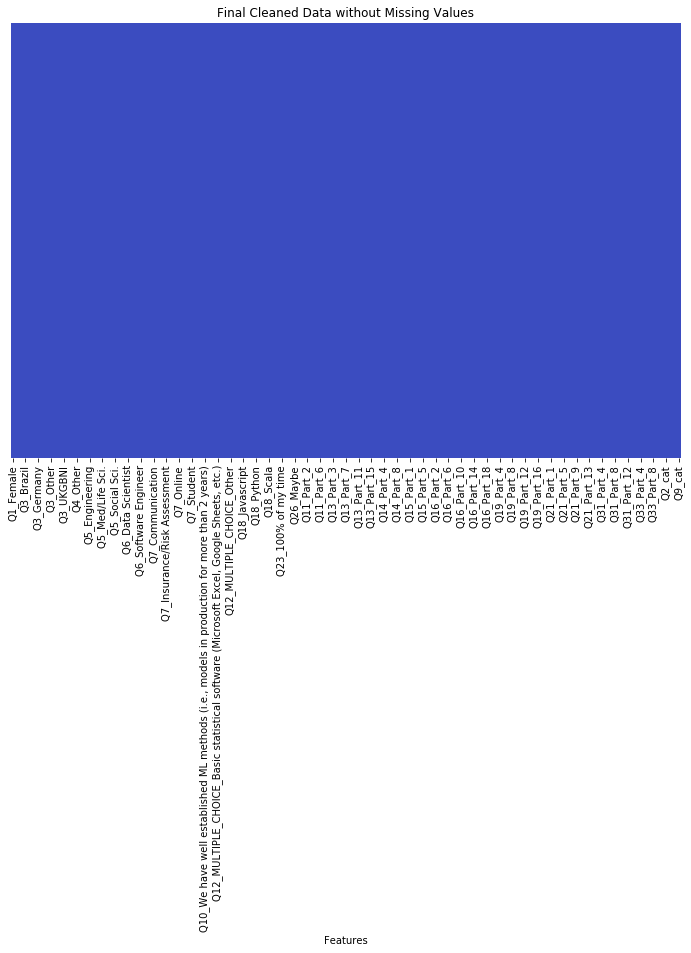

In [65]:
# plot the final cleaned data with no missing values
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(cleaned_data.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
plt.title('Final Cleaned Data without Missing Values')
plt.xlabel('Features')

## 2. Exploratory Data Analysis

In this section, Exploratory Data Analysis is performed to find trends that may help with predicting yearly compensation. To begin, I plotted the correlation graph between each feature of the completely cleaned dataset and the target variable. This graph provides an idea of the importance of each feature in dictating the salaries earned. Based on the results, the top 5 highest correlations with salary are:
    1. Whether you work in the USA or not
    2. Your age
    3. How long you have been writing code to analyze data
    4. The amount of years you have worked in your current role
    5. The amount of years you have used ML methods

Text(0, 0.5, 'Correlation Value')

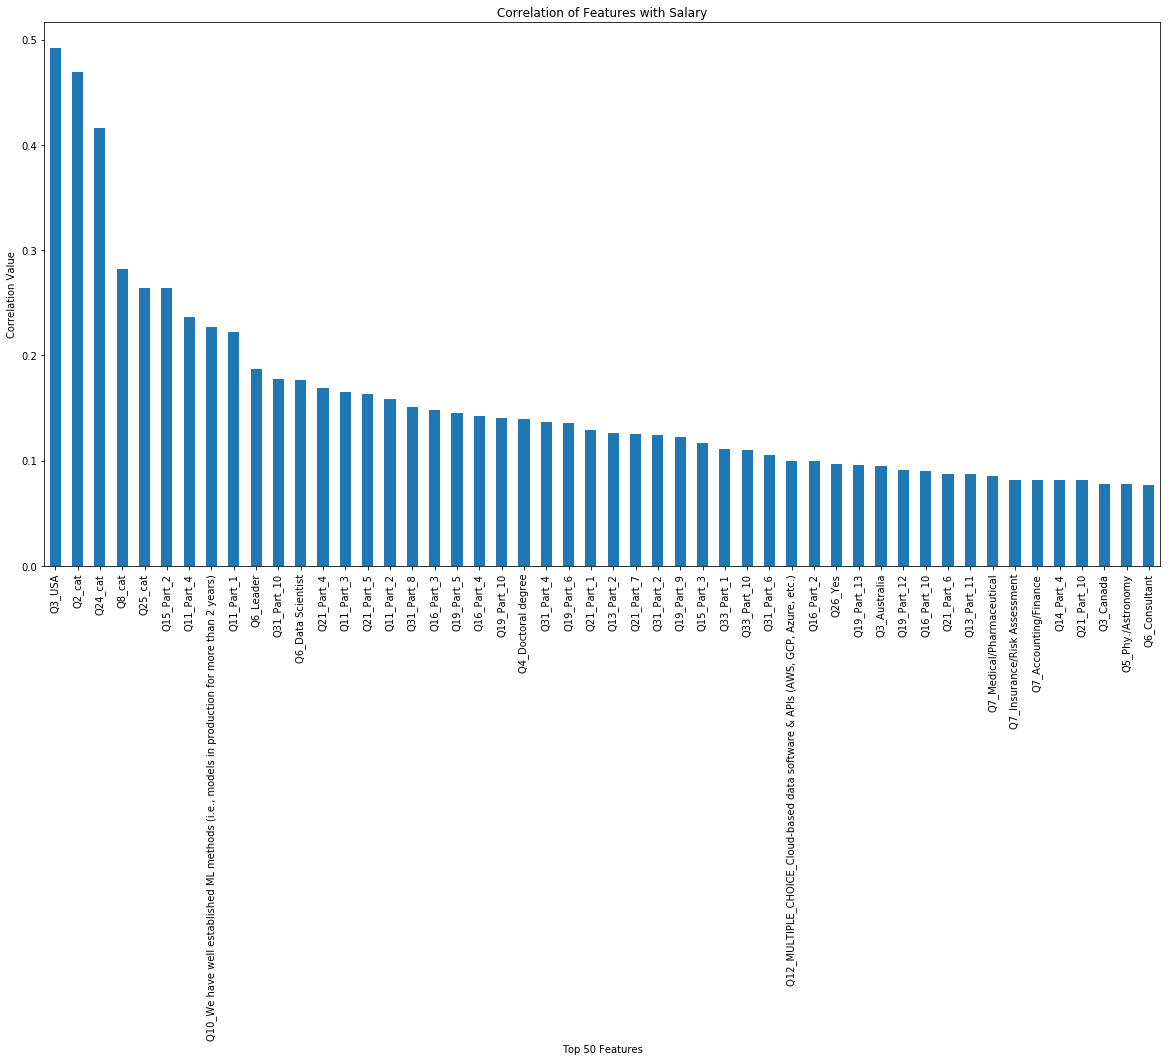

In [66]:
# plotting correlation between salary and features
corr = cleaned_data.corr()
salary_row = corr.shape[0]-1
correlation = corr.iloc[salary_row,0:salary_row].sort_values(ascending=False)
# show top 50 correlations with salary
plt.subplots(figsize=(20,10))
correlation.iloc[0:50].plot(kind='bar')
plt.title('Final Cleaned Data without Missing Values')
plt.xlabel('Features')
plt.title('Correlation of Features with Salary')
plt.xlabel('Top 50 Features')
plt.ylabel('Correlation Value')

Looking at each of the top 5 features more closely, I will be presenting a few more graphical features to provide better understanding of the data. Starting with the first correlation, which is ultimately about where the surveyee works. Plotting the relationship between countries and salary, it seems that on average, those who work in the USA earn the highest amount of salaries when compared to those who do not. While India and China are the two countries with the second and third most entries, they both earn the least.

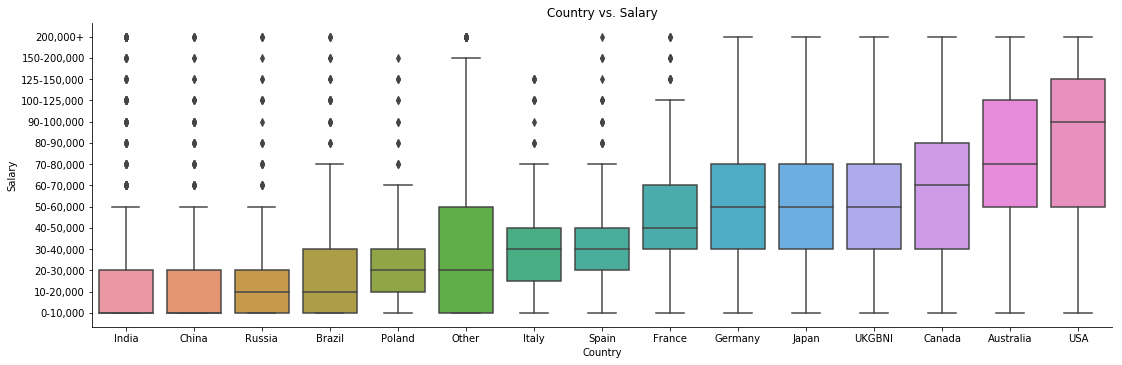

In [67]:
# plot the country vs salary
g = sns.catplot(x='Q3', y='Q9_cat', data=data, order = ['India','China','Russia','Brazil','Poland','Other','Italy','Spain','France','Germany','Japan','UKGBNI','Canada','Australia','USA'],
                kind="box", height=5, aspect=3)
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Country", "Salary")
plt.title("Country vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

The second strongest correlation is based on the age of the surveyee where it is evident in the following plot that as one becomes older, the more salary one earns.

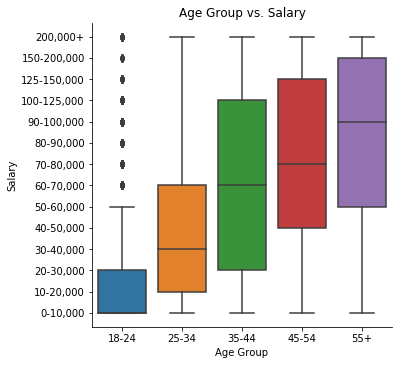

In [68]:
# plot age vs salary
g = sns.catplot(x='Q2', y='Q9_cat', data=data, order = ['18-24','25-34', '35-44','45-54','55+'], kind="box")
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Age Group", "Salary")
plt.title("Age Group vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

The third strongest correlation is regarding the amount of years one have spent writing code to analyze data. To no surprise, the more years of experience someone has, the more salary someone earns.

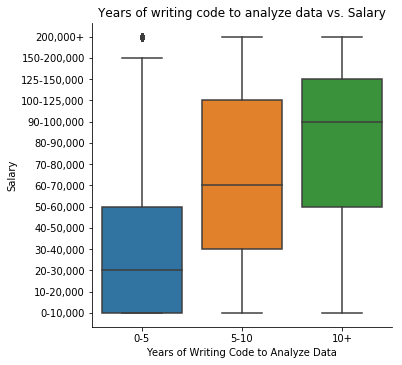

In [69]:
# plot years of writing code to analyze data
g = sns.catplot(x='Q24', y='Q9_cat', data=data, order=['0-5', '5-10','10+'], kind="box")
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Years of Writing Code to Analyze Data", "Salary")
plt.title("Years of writing code to analyze data vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

The fourth strongest correlation is the years of experience in the current role where similar to the previous feature, the more experience someone has equates to a higher salary and vice versa.

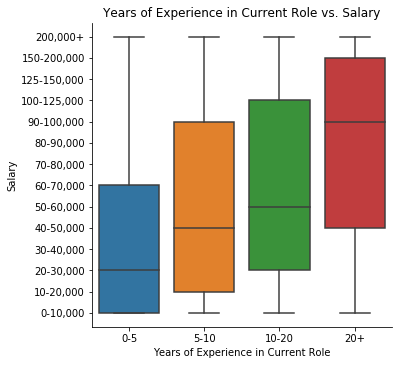

In [70]:
# plot years of experience in current role vs salary
g = sns.catplot(x='Q8', y='Q9_cat', data=data, order = ['0-5','5-10', '10-20','20+'], kind="box")
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Years of Experience in Current Role", "Salary")
plt.title("Years of Experience in Current Role vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

Lastly, the years of experience with ML techniques also play a role in dictating ones salary.

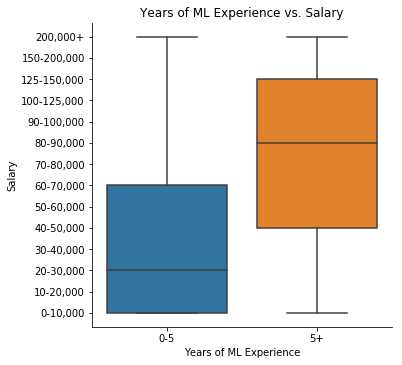

In [71]:
# plot years of ML experience
g = sns.catplot(x='Q25', y='Q9_cat', data=data, order=['0-5', '5+'], kind="box")
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Years of ML Experience", "Salary")
plt.title("Years of ML Experience vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

The following illustrates the correlation matrix between all the variables of the cleaned data. This is useful for further analysis on the features that exist in this dataset.

In [1]:
# correlation matrix
f = plt.figure(figsize=(10, 10))
corr = cleaned_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

## 3. Feature Selection

In this section, feature engineering is first discussed to create new features based on existing ones. This is followed by feature selection where the purpose is to choose only the features that are most relevant by getting rid of useless features. In the case of this assignment, the task is to predict salaries; therefore, features that either do not contribute or negatively impact the accuracy should not be used. This will create a model that requires less data which translates to a less complicated model with faster convergence. There are several types of feature selection algorithms available and they are categorized in to one of the three types below.

*Filter Methods*: This type of method assigns a score to each feature based on some forms of statistical measure. The score of each feature are sorted based on magnitude with only the highest kept. With this type of method, each feature is considered to be independent.

*Wrapper Methods*: Instead of considering features to be independent such as Filter Methods, Wrapper Methods group together different combination of features and perform a search for the model with the best set of features. These sets are then assigned a score accordingly where the best set of features are kept in the end.

*Embedded Methods*: Lastly, Embedded Methods are a type of selection method that learns which features are most important during the fitting of the model.

In section 3.1, feature engineering will be discussed, and section 3.2 will discuss the implementation of an embedded feature selection method while section 3.3 will implement a dimension reduction algorithm.

### 3.1 Feature Engineering 

Starting with feature engineering, which is a technique used to create new features based on raw features by either splitting or combining original features. In this case, I have looked at 6 features from the cleaned dataset in particular, which are listed below. 

    1. Q13: Which IDE's have you used at work/school in the last 5 years? 
    2. Q14: Which hosted notebooks have you used at work/school in the last 5 years?
    3. Q15: Which cloud computing services have you used at work/school in the last 5 years?
    4. Q16: What programming languages do you use on a regular basis?
    5. Q19: What machine learning frameworks have you used in the past 5 years?
    6. Q21: What data visualization libraries/tools have you used in the last 5 years?
    
Each of these features asks the surveyees whether they have used any of the suggested tools in the last 5 years. Based on intuition, someone who's worked with multiple tools/frameworks/software should imply that they have great experience in the field. On the other hand, someone who did not select any or only a few, should imply that they are inexperienced. As a result, the number of choices one made in each question should have a correlation with salary earnings.

In the code below, I have combined the features from each of these questions by summing the counts over the respective columns (since each column was one hot encoded previously, this is merely a task of adding integers across columns).

In [73]:
# new_features
Q13_combined = encoded_dropped.Q13 # Number of IDE's used
Q14_combined = encoded_dropped.Q14 # Number of hosted notebooks used
Q15_combined = encoded_dropped.Q15 # Number of cloud computing services used
Q16_combined = encoded_dropped.Q16 # Number of programming language used
Q19_combined = encoded_dropped.Q19 # Number of ML frameworks used
Q21_combined = encoded_dropped.Q21 # Number of Data Visualization libraries/tools used
# combine them in to one dataframe while making sure the columns are labelled
new_features = pd.concat([Q13_combined, Q14_combined, Q15_combined, Q16_combined, Q19_combined, Q21_combined], axis=1)
new_features.columns = ['Q13_nskills','Q14_nskills','Q15_nskills','Q16_nskills','Q19_nskills','Q21_nskills']
# combine with the rest of the cleaned data
cleaned_data = pd.concat([cleaned_data, new_features], axis=1)
# move salary label to the last column
cols_ = list(cleaned_data.columns.values) #Make a list of all of the columns in the df
cols_.pop(cols_.index('Q9_cat')) #Remove b from list
cleaned_data = cleaned_data[cols_+['Q9_cat']] #Create new dataframe with columns in the order you want

#### Q13: Number of IDE's Used 

The following plot presents the number of IDE's used against the salary range. Contrary to my initial intuition, it seemed that a weak correlation exists between the number of IDE's used and salary earnings (this is also evident based on the correlation value of 0.012). As seen in the results, the salary stayed relatively similar despite increase in number of IDE's used up to 12. Those who has have worked with 13 IDE's show that they make significantly more than the rest; however, those with 14 make significantly less. The reason behind this trend is likely due to the fact that the question did not specify which IDE's a surveyee is most proficient with, instead the question merely asks whether the surveyee has "worked" with the IDE. For example, students who have taken many courses could have lightly used lots of IDE's but is not an expert at any specific one.

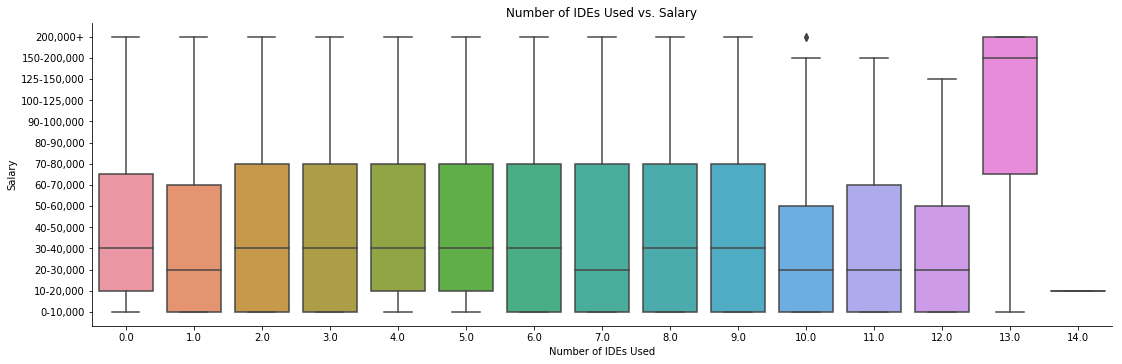

In [74]:
# Q13: Number of IDE's Used vs. Salary
g = sns.catplot(x='Q13_nskills', y='Q9_cat', data=cleaned_data, kind="box", height=5, aspect=3)
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Number of IDEs Used", "Salary")
plt.title("Number of IDEs Used vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

In [75]:
# correlation of the number of IDE's used with the salary
cleaned_data.Q13_nskills.corr(cleaned_data.Q9_cat)

0.012351587806350713

#### Q14: Number of Hosted Notebooks Used

The following plots the relationship between the number of hosted notebooks used and the salary range. Based on the results, it appears that the more notebooks one have worked with, the more salary one earns. However, the correlation value of 0.0029 implies otherwise. This is likely because the majority of the data fall under low earnings, with not enough to support those who earn higher salary ranges. 

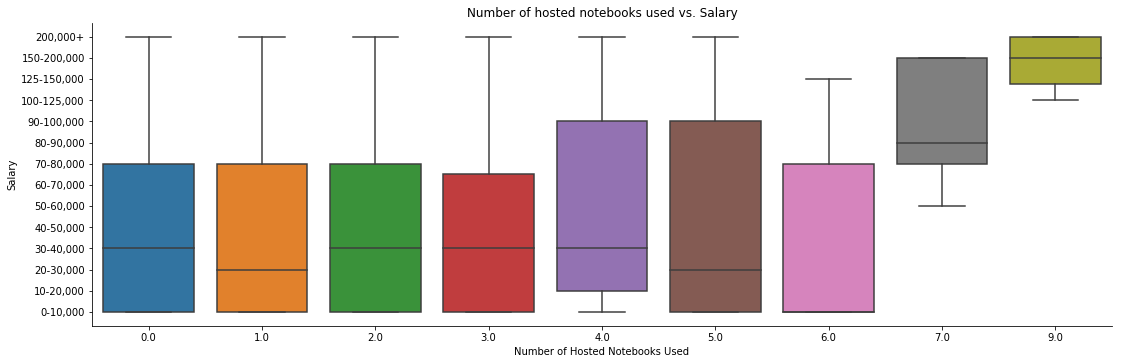

In [76]:
# Q14: Number of hosted notebooks used
g = sns.catplot(x='Q14_nskills', y='Q9_cat', data=cleaned_data, kind="box", height=5, aspect=3)
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Number of Hosted Notebooks Used", "Salary")
plt.title("Number of hosted notebooks used vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

In [77]:
# correlation of the number of hosted notebooks used with the salary
cleaned_data.Q14_nskills.corr(cleaned_data.Q9_cat)

0.002851226607898226

#### Q15: Number of Cloud Computing Services Used

The plot below shows the relationship between the number of cloud computing servies used and the salary ranges. Based on the figure as well as the calculated correlation of 0.21, it appears that there is a correlation between the two variables.

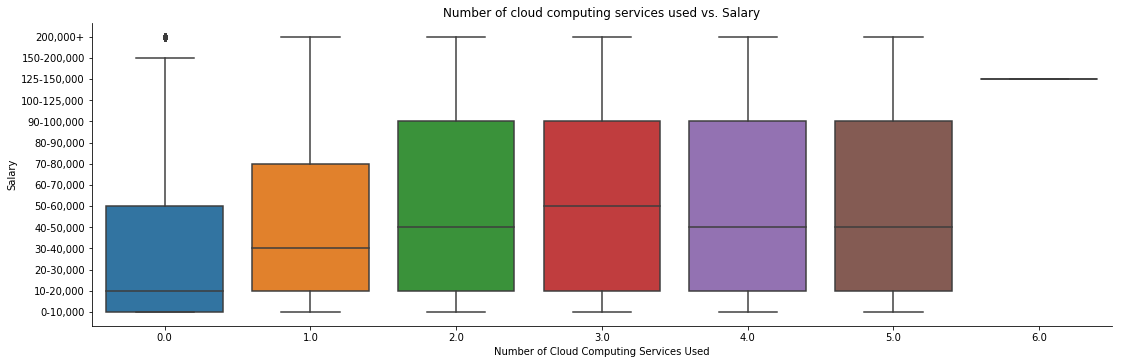

In [78]:
# Plot Q15 number of cloud computing servies used
g = sns.catplot(x='Q15_nskills', y='Q9_cat', data=cleaned_data, kind="box", height=5, aspect=3)
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Number of Cloud Computing Services Used", "Salary")
plt.title("Number of cloud computing services used vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

In [79]:
# correlation of the number of cloud computing services used with the salary
cleaned_data.Q15_nskills.corr(cleaned_data.Q9_cat)

0.20684327664930424

#### Q16: Number of Programming Language Used

The following plot shows the number of programming language used against the salary ranges. Contrary to my intuition, it seems that there isn't a strong correlation between the two variables as the salary stays relatively the same despite the increase in languages used. At high amount of languages used, the salary ranges jumps from low to high without consistency. This is likely due to the fact that there are not enough data available for high salary ranges.

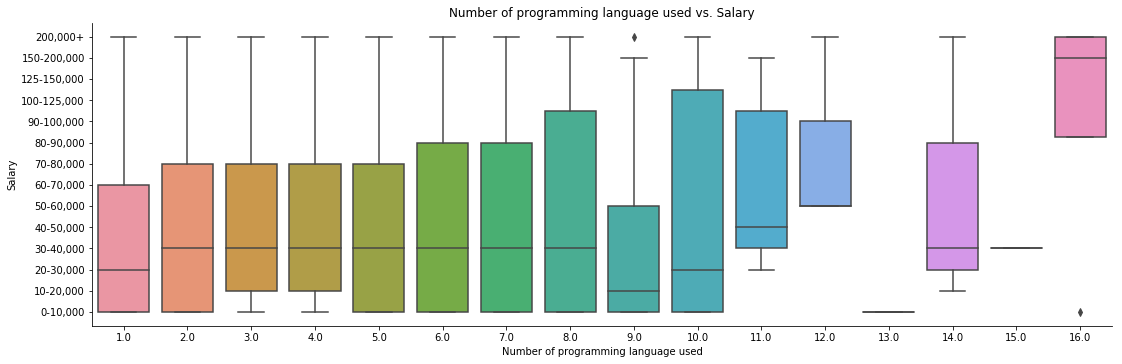

In [80]:
# plot Q16 number of programming language used
g = sns.catplot(x='Q16_nskills', y='Q9_cat', data=cleaned_data, kind="box", height=5, aspect=3)
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Number of programming language used", "Salary")
plt.title("Number of programming language used vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

In [81]:
# correlation of the number of programming language used with the salary
cleaned_data.Q16_nskills.corr(cleaned_data.Q9_cat)

0.06729324956910915

#### Q19: Number of ML Frameworks Used

The following shows the relationship between the number of ML frameworks used against the salary ranges. It appears that there is a steady increase in salary with the number of frameworks used up to around 11 where the data starts to become sparse. Based on the calculated correlation value of 0.17, this correlation resembles that of Q15.

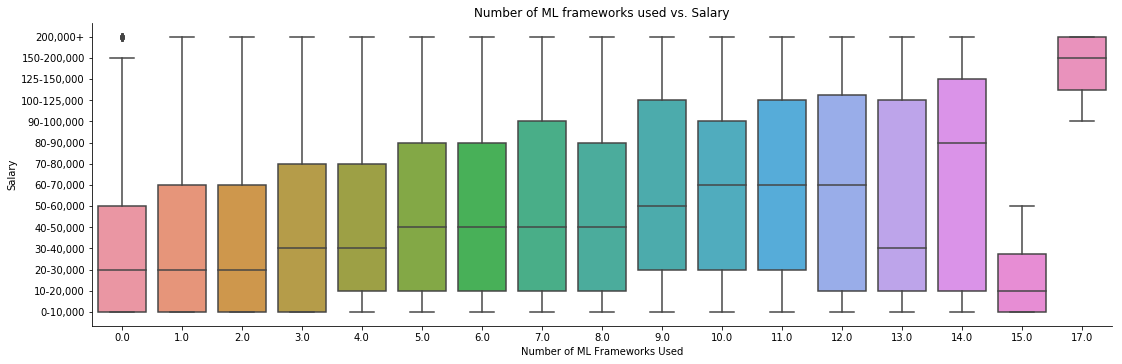

In [82]:
# plot Q19 number of ML frameworks used
g = sns.catplot(x='Q19_nskills', y='Q9_cat', data=cleaned_data, kind="box", height=5, aspect=3)
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Number of ML Frameworks Used", "Salary")
plt.title("Number of ML frameworks used vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

In [83]:
# correlation of the number of ML farmworks used with the salary
cleaned_data.Q19_nskills.corr(cleaned_data.Q9_cat)

0.17093069312281284

#### Q21: Number of Data Visualization Libraries/Tools used

The following plot shows the relationship between the number of data visualization libraries/tools used with the salary earnings. Based on the calculated correlation of 0.18 and the overall trend of the graph, it appears that as the number of tools used increase, so does the average income.

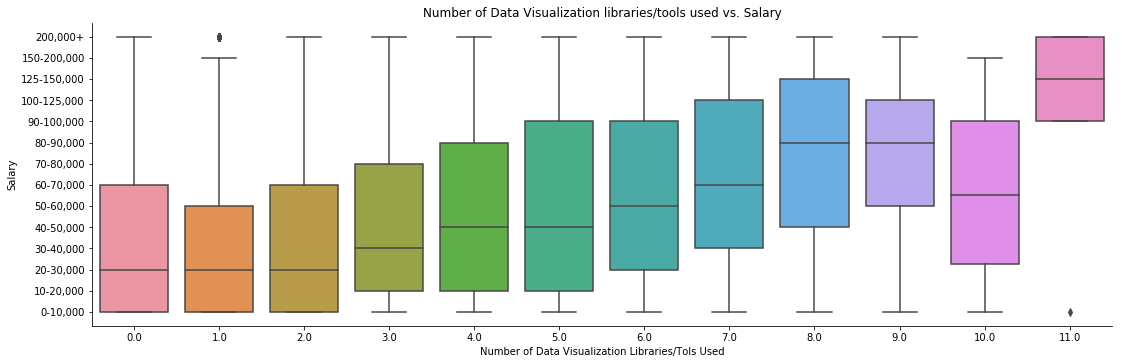

In [84]:
# plot Q21 number of data visualization libraries/tools used with salary
g = sns.catplot(x='Q21_nskills', y='Q9_cat', data=cleaned_data, kind="box", height=5, aspect=3)
ylabels = list(Q9_label.values())
g.set_yticklabels(ylabels)
g.set_axis_labels("Number of Data Visualization Libraries/Tols Used", "Salary")
plt.title("Number of Data Visualization libraries/tools used vs. Salary")
g.set(yticks=range(0,len(Q9_label)))

In [85]:
# correlation of the number of Data visualization libraries used with the salary
cleaned_data.Q21_nskills.corr(cleaned_data.Q9_cat)

0.1847875778120865

#### Top 50 Feature Correlations with the Salary

Plotting the feature correlations with the salary again shows that 3 of the 6 engineered features have made it to the top 50 with 
    - Q15_nskills (Number of cloud computing services) at spot 10, 
    - Q21_nskills (Number of data visualization tools) at spot 12 and 
    - Q19_nskills (Number of ML frameworks used) at 15.

Text(0, 0.5, 'Correlation Value')

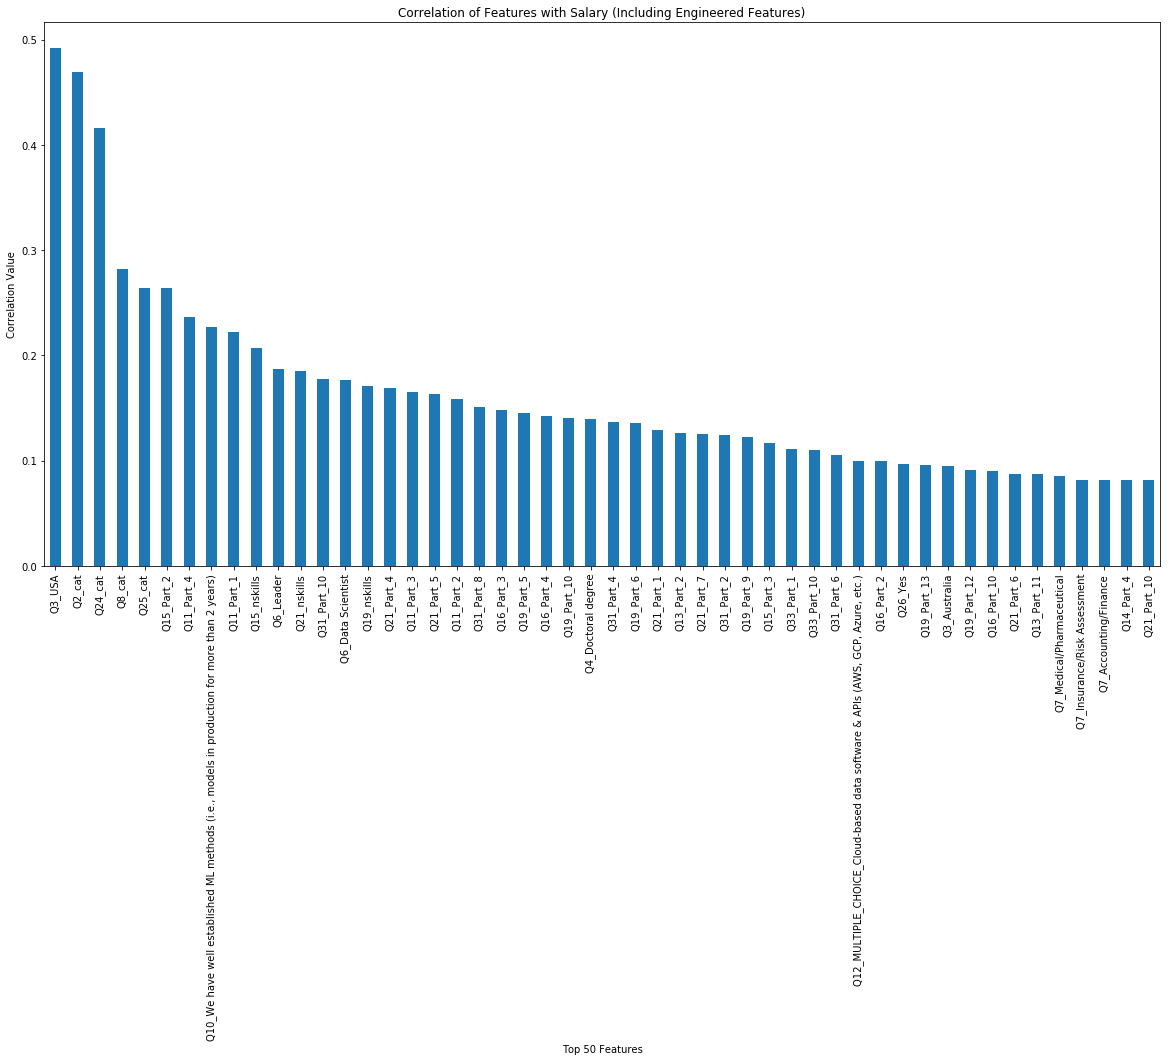

In [86]:
# plotting correlation between salary and features
corr = cleaned_data.corr()
salary_row = corr.shape[0]-1
correlation = corr.iloc[salary_row,0:salary_row].sort_values(ascending=False)
# show top 50 correlations with salary
plt.figure(figsize=(20,10))
correlation.iloc[0:50].plot(kind='bar')
plt.title('Correlation of Features with Salary (Including Engineered Features)')
plt.xlabel('Top 50 Features')
plt.ylabel('Correlation Value')

### 3.2 Feature Selection

In this section, an embedded method feature selection technique using a random forest classifier is applied to choose the most relevant features. A random forest classifier is an ensemble machine learning algorithm that is built on the foundation of decision trees. At each node in the decision tree, an impurity measure known as the "Gini Impurity" is associated. While the tree is building, the impurity is calculated. When the tree is completed, feature selection is accomplished by selecting features with the highest importance that is calculated based on the Mean Decrease in Impurity (MDI). Advantages of random forest classifier include its ability to not overfit the model as well as its ability to handle large datasets with high dimensionality.

In the code below, the cleaned dataset is split in to training (70%) and testing (30%).

In [87]:
# split the cleaned data
X = cleaned_data.drop(['Q9_cat'],axis=1)
y = cleaned_data['Q9_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.3)

Currently, the cleaned dataset has 214 features. Prior to fitting the training data, both the train and test sets are scaled as some features have larger values than others (difference in magnitude, units, range ... etc.). In this case, the standard scaler is used which changes the distribution to a mean of zero and a standard dviation of one. Without scaling, the model could result in poor performance as machine learning algorithms tends to use Eucledian distance between data points for learning. The implementation of the classifer below reduced the overall features from 214 down to roughly 100 features (the number changes +/- 5 with each execution).

In [88]:
# scale
scaler = StandardScaler()
X_train_FS = scaler.fit_transform(X_train)
X_test_FS = scaler.transform(X_test)
# Random Forest Feature Selection
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train_FS, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 214
selected features: 97


The training and testing feature sets are converted accordingly to use the features that were deemed important based on the results from the feature selection algorithm.

In [89]:
# convert selected features to a list
selected_list=[]
for i in range(len(selected_feat)):
    selected_list.append(selected_feat[i])
# create processed training and test data based on selected features
X_train_proc = X_train[X_train.columns.intersection(selected_list)]
X_test_proc = X_test[X_test.columns.intersection(selected_list)]

### 3.3 Principle Component Analysis

Another form of feature selection is known as dimension reduction. In dimension reduction, original features are combined and reduced to form new features. A type of dimension reduction method is called Principle Component Analysis (PCA) which utilizes unsupervised machine learning. Besides combining features, the created new features are independent of one another and they are ranked according to the variance among them.

In the code below, I specified 50 as the desired amount of resultant components (I wanted a second dataset that is approximately half of the one generated by random forest). The intention here is to create two sets of data: one with the features selected based on random forest, the other (here) selected based on PCA. In the next section, I will train 2 logistic regression models to compare the performance difference between the two methods of selecting/generating features.

In [90]:
from sklearn.decomposition import PCA
# specifie how many principle components wanted
pca = PCA(n_components = 50)
# scale
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train)
X_test_pca = scaler.transform(X_test)
# fit
pca.fit(X_train_pca)
# transform to both training and test set
X_train_pca = pca.transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)
# convert to dataframe
X_train_pca = pd.DataFrame(data=X_train_pca[0:,0:],
                          index=[i for i in range(X_train_pca.shape[0])],
                          columns=['P'+str(i) for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(data=X_test_pca[0:,0:],
                          index=[i for i in range(X_test_pca.shape[0])],
                          columns=['P'+str(i) for i in range(X_test_pca.shape[1])])

Below shows the first 5 rows of the resultant components where each column represents a new feature that is made up of original features (each column is no longer associated to a specific feature).

In [91]:
X_train_pca.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49
0,-2.235900,5.778664,-1.198117,0.735375,3.103845,-0.995306,1.273976,1.886381,-0.304905,1.157795,...,0.307990,-0.510180,0.553963,0.661145,0.620422,-0.659827,-0.062108,-0.458952,0.359358,-1.322665
1,-2.986304,2.996480,-0.734213,2.992518,-0.686594,0.921133,-1.109498,-2.815839,2.079625,-0.420994,...,-0.564629,-0.369893,0.876043,0.406229,-0.019762,0.160681,0.740193,1.842244,-0.787654,-0.186835
2,-0.134643,1.840058,0.859134,-0.248236,-2.146240,0.670089,-0.053868,-0.204343,-1.671844,1.147167,...,-0.878435,0.401783,0.433678,0.124609,-1.407430,0.912886,1.092935,-0.232507,-0.505309,-0.726424
3,-0.209706,2.202937,-2.285195,-0.239530,1.928913,0.152966,-1.294570,1.108772,0.651116,2.514894,...,-1.480974,-0.630684,0.436806,-1.986311,-0.184349,-1.346078,-0.540561,-0.133439,0.364982,1.272163
4,3.621414,4.634360,-0.514160,-1.403172,0.136055,-3.063580,1.397836,-0.365603,-0.768876,2.660238,...,0.549364,0.659198,0.298390,1.136153,0.861054,-1.762798,-1.357146,-1.738856,1.470546,-1.041120


## 4. Model Implementation

In this section, two logistic regression models are fitted with the two feature selected datasets (one from Random Forest, the other from PCA). The results of the two models are compared by looking at their respective confusion matrices as well as the scores from cross validation.

### 4.1 Logistic Regression

The code below creates 2 models, one from the random forest selected dataset while the other is from the PCA selected dataset.

In [92]:
import warnings
warnings.filterwarnings("ignore")
# fit model with RANDOM FOREST FEATURE SELECTED DATASET
FS_model = LogisticRegression(multi_class = 'ovr')
FS_model.fit(X_train_proc, y_train)    
FS_predictions = FS_model.predict(X_test_proc)
# fit model with PCA SELECTED DATASET
PCA_model = LogisticRegression(multi_class = 'ovr')
PCA_model.fit(X_train_pca, y_train)    
PCA_predictions = PCA_model.predict(X_test_pca)

### 4.2 Confusion Matrix

The following 2 plots shows the confusion matrix for the model trained with the random forest selected dataset and the PCA selected data. Based on the results, it is apparent that classification for "0-10,000" and "10-20,000" performed the best while the rest did poorly. The results for the PCA selected model also showed slightly improved performance. 

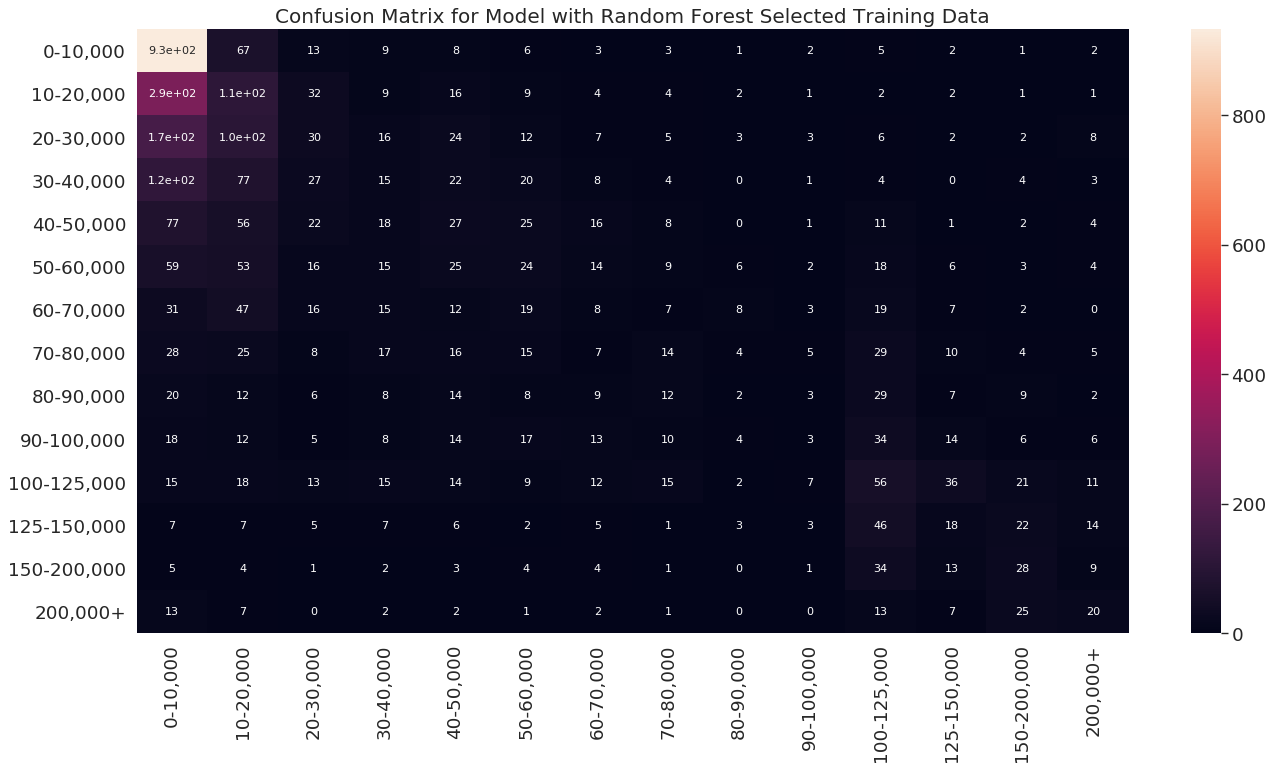

In [93]:
# Confusion matrix for RANDOM FOREST selected dataset
from matplotlib.pyplot import figure
import sklearn.metrics as metrics
cm=metrics.confusion_matrix(y_test,FS_predictions)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
df_cm = pd.DataFrame(cm, range(cm.shape[0]),range(cm.shape[1]))
g = sns.set(font_scale=1.5)#for label size
g = sns.heatmap(df_cm, annot=True,annot_kws={"size": 10}) # font size
labels = Q9_order
_ = g.set_yticklabels(labels)
_ = g.set_xticklabels(labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
_ = plt.title("Confusion Matrix for Model with Random Forest Selected Training Data")

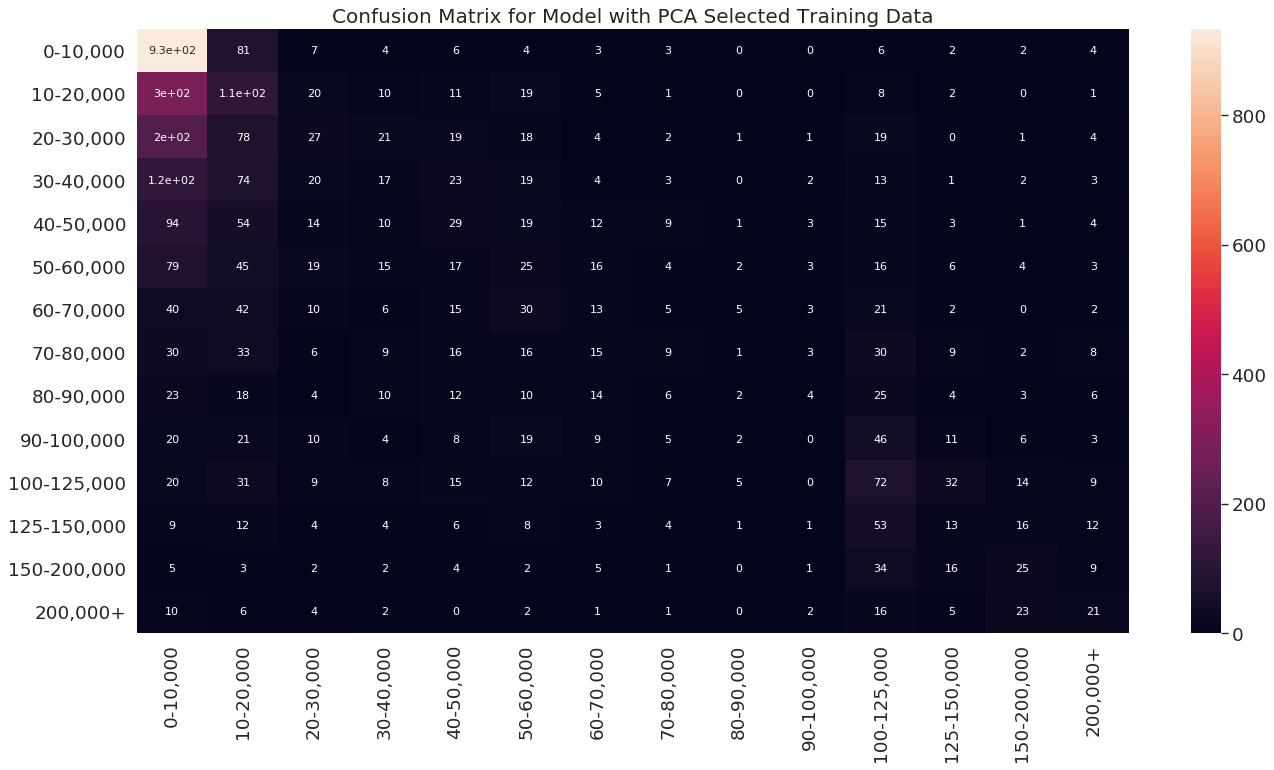

In [94]:
# Confusion matrix for PCA selected dataset
cm=metrics.confusion_matrix(y_test,PCA_predictions)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
df_cm = pd.DataFrame(cm, range(cm.shape[0]),range(cm.shape[1]))
g = sns.set(font_scale=1.5)#for label size
g = sns.heatmap(df_cm, annot=True,annot_kws={"size": 10}) # font size
labels = Q9_order
_ = g.set_yticklabels(labels)
_ = g.set_xticklabels(labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
_ = plt.title("Confusion Matrix for Model with PCA Selected Training Data")
plt.show()

One thing to note is that the "100-125,000" class did better than the remaining classes besides the first two that were mentioned ("0-100,000", "10-20,000"). The reason for this is likely due to the distribution of the training dataset where the majority of survyees earned salaries within the first two classes with very little data available regarding the other salary ranges except for the slight increase at "100-125,000". The following is a plot showing the salary distribution which helps understand why the majority of the classes did poorly.

Text(0.5, 1.0, 'Salary Range vs. Count')

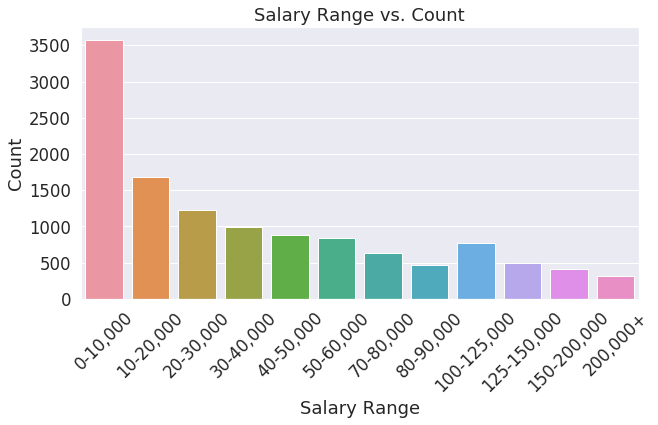

In [95]:
# plot salary distribution of the dataset
plt.figure(figsize=(10,5))
g = sns.countplot(x='Q9', data=data, order=['0-10,000', '10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','70-80,000','80-90,000','100-125,000','125-150,000','150-200,000','200,000+'])
g.set(xlabel='Salary Range', ylabel='Count')
plt.xticks(rotation=45)
plt.title("Salary Range vs. Count")

### 4.3 K-Fold Cross Validation

In K-Fold Cross Validation, the training dataset is divided in to *K* folds where *K-1* folds are then used as training, and testing is done on the last fold. Each of the folds becomes the testing fold once; therefore, a 10 fold cross validation process divides the data in to 10 sections, and the training and testing repeats for a total of 10 times (when every fold has become the test set once). The motive behind this technique is to provide a better understanding of the performance of the machine learning model in a less biased/optimistic perspective.

The following two code cells implements a 10 fold cross validation where the average accuracy for both the models showed insignificant difference. The average accuracy of each fold hovers around 32% with the standard deviation and variance of the average accuracy approximately 1.4% and 1.5, respectively.

Since both the models performed similar, I will continue the rest of the assignment with only the dataset selected from PCA since it has less features (faster execution).

In [96]:
# 10 fold cross validation for the model trained on RANDOM FOREST selected features
kfold = model_selection.KFold(n_splits=10, random_state=1)
scoring = 'accuracy'
model = LogisticRegression()
results = model_selection.cross_val_score(model, X_train_proc, y_train, cv=kfold, scoring=scoring)
fold = 0
print("Cross Validation for Model with Random Forest Selected Dataset")
for i in results:
    score = i * 100
    fold += 1
    print("Fold "+ str(fold) + " Accuracy: " + str(round(score,2)) + "%")
average_score = results.mean()*100
score_std = results.std()*100
print("Average Accuracy: " + str(round(average_score,2)) + "% Standard Deviation (" + str(round(score_std,2)) + "%)") 
print("Variance: " + str(round(pow(score_std, 2), 2)))

# hard coded to show results from above
print("Cross Validation for Model with Random Forest Selected Dataset")
print("Fold 1 Accuracy: 32.45%")
print("Fold 2 Accuracy: 30.97%")
print("Fold 3 Accuracy: 33.23%")
print("Fold 4 Accuracy: 30.25%")
print("Fold 5 Accuracy: 31.42%")
print("Fold 6 Accuracy: 31.53%")
print("Fold 7 Accuracy: 33.23%")
print("Fold 8 Accuracy: 33.33%")
print("Fold 9 Accuracy: 30.15%")
print("Fold 10 Accuracy: 31.1%")
print("Average Accuracy: 31.77% Standard Deviation (1.16%) Variance: 1.33")

Cross Validation for Model with Random Forest Selected Dataset
Fold 1 Accuracy: 32.45%
Fold 2 Accuracy: 30.97%
Fold 3 Accuracy: 33.23%
Fold 4 Accuracy: 30.25%
Fold 5 Accuracy: 31.42%
Fold 6 Accuracy: 31.53%
Fold 7 Accuracy: 33.23%
Fold 8 Accuracy: 33.33%
Fold 9 Accuracy: 30.15%
Fold 10 Accuracy: 31.1%
Average Accuracy: 31.77% Standard Deviation (1.16%) Variance: 1.33


In [97]:
# 10 fold cross validation for the model trained on PCA selected features
kfold = model_selection.KFold(n_splits=10, random_state=1)
scoring = 'accuracy'
model = LogisticRegression()
results = model_selection.cross_val_score(model, X_train_pca, y_train, cv=kfold, scoring=scoring)
fold = 0
print("Cross Validation for Model with PCA Selected Dataset")
for i in results:
    score = i * 100
    fold += 1
    print("Fold "+ str(fold) + " Accuracy: " + str(round(score,2)) + "%")
average_score = results.mean()*100
score_std = results.std()*100
print("Average Accuracy: " + str(round(average_score,2)) + "% Standard Deviation (" + str(round(score_std,2)) + "%)") 
print("Variance: " + str(round(pow(score_std, 2), 2)))

#hard coded to show results from above
print("Cross Validation for Model with PCA Selected Dataset")
print("Fold 1 Accuracy: 32.03%")
print("Fold 2 Accuracy: 30.43%")
print("Fold 3 Accuracy: 32.27%")
print("Fold 4 Accuracy: 31.74%")
print("Fold 5 Accuracy: 34.08%")
print("Fold 6 Accuracy: 33.86%")
print("Fold 7 Accuracy: 33.33%")
print("Fold 8 Accuracy: 32.27%")
print("Fold 9 Accuracy: 29.72%")
print("Fold 10 Accuracy: 31.63%")
print("Average Accuracy: 32.14% Standard Deviation (1.32%) Variance: 1.74")

Cross Validation for Model with PCA Selected Dataset
Fold 1 Accuracy: 32.03%
Fold 2 Accuracy: 30.43%
Fold 3 Accuracy: 32.27%
Fold 4 Accuracy: 31.74%
Fold 5 Accuracy: 34.08%
Fold 6 Accuracy: 33.86%
Fold 7 Accuracy: 33.33%
Fold 8 Accuracy: 32.27%
Fold 9 Accuracy: 29.72%
Fold 10 Accuracy: 31.63%
Average Accuracy: 32.14% Standard Deviation (1.32%) Variance: 1.74


#### Hyperparameters and the Bias-Variance Trade-Off

*The assignment asks "Treating each value of hyperparameter(s) as a new model, which model performed best?*

Hyperparameters are responsible for the behaviour of machine learning algorithms during training, which in turn effects the performance of the output model. As such, they are initialized and tuned before the training of the final optimal model. 

In the case of logistic regression, one of the hyperparameters to tune is the *C* value, which is called the regularization parameter. This parameter is inversely proportional to the lambda regulator which is responsible for determining how likely parameters are to be adjusted based on perturbations in the dataset. In other words, the smaller the regularization parameter (*C*), the larger the lambda regulator which in turn cancels out parameters to make for a simple model that is likely to underfit. On the contrary, the higher the regularization parameter, the lower the lambda regular and more parameters are kept which makes for a complex model that is likely to overfit. Furthermore, a model is underfitted when the variance and bias are low and high, respectively. On the other hand, a model is overfitted when the variance and bias are high and low, respectively. 

The goal is to find the best regularization parameter such that the model is able to generalize well over unseen data. In the code below, 6 models are created, each with a different regularization parameter. The results showed that with a C value of 1 performs the best (the score changes with every run due to the different splits completed by PCA for the training dataset). In other words, at this regularization parameter, the bias and variance trade off is optimized.

In [98]:
# create different models with a different C value
C_list = [0.001,0.01,0.05,0.1,0.5,1, 5]
model1= LogisticRegression(C=C_list[0], multi_class = 'ovr')
model2= LogisticRegression(C=C_list[1], multi_class = 'ovr')
model3= LogisticRegression(C=C_list[2], multi_class = 'ovr')
model4= LogisticRegression(C=C_list[3], multi_class = 'ovr')
model5= LogisticRegression(C=C_list[4], multi_class = 'ovr')
model6= LogisticRegression(C=C_list[5], multi_class = 'ovr')
model7= LogisticRegression(C=C_list[6], multi_class = 'ovr')
# fit the different models with the same training set
model1.fit(X_train_pca, y_train)
model2.fit(X_train_pca, y_train)
model3.fit(X_train_pca, y_train)
model4.fit(X_train_pca, y_train)
model5.fit(X_train_pca, y_train)
model6.fit(X_train_pca, y_train)
model7.fit(X_train_pca, y_train)
# print the scores of each model on the test set
print("Model1 Score: " + str(round(model1.score(X_test_pca, y_test)*100, 2)) + "%")
print("Model2 Score: " + str(round(model2.score(X_test_pca, y_test)*100, 2)) + "%")
print("Model3 Score: " + str(round(model3.score(X_test_pca, y_test)*100, 2)) + "%")
print("Model4 Score: " + str(round(model4.score(X_test_pca, y_test)*100, 2)) + "%")
print("Model5 Score: " + str(round(model5.score(X_test_pca, y_test)*100, 2)) + "%")
print("Model6 Score: " + str(round(model6.score(X_test_pca, y_test)*100, 2)) + "%")
print("Model7 Score: " + str(round(model7.score(X_test_pca, y_test)*100, 2)) + "%")

Model1 Score: 31.49%
Model2 Score: 31.77%
Model3 Score: 31.96%
Model4 Score: 31.94%
Model5 Score: 32.14%
Model6 Score: 32.19%
Model7 Score: 32.21%


## 5. Model Tuning

Previously, different hyperparameters were manually used to check model accuracy. In this section, a grid search method is implemented to exhaustively try out every specified hyperparameter combinations with cross validation to find the best hyperparameter values for the model. It is important to note that the cross validation is completed on just the training data (the original 70%), ensuring that the model has never seen the original test set (30%).

In [99]:
%%time

model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

C_list = [0.001,0.01,0.05,0.1,0.5,1,10]
solver_list = ['newton-cg','lbfgs','liblinear','sag']

# use the Random Forest selected dataset
X_proc = X_train_pca

for C in C_list:
    for solver in solver_list:
        # show progress percentage
        current_c = C_list.index(C)+1
        progress = ((current_c-1)/len(C_list))*100
        clear_output(wait=True)
        print('Progress: ' + str(round(progress, 2)) +' %. Solver: ' + solver)
        
        model = LogisticRegression(C=C, solver=solver)
        accuracy = np.zeros(10)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X_proc):
            X_train_tune, X_test_tune = X_proc.values[train_idx], X_proc.values[test_idx]
            y_train_tune, y_test_tune = y_train.values[train_idx], y_train.values[test_idx]

            X_train_tune = scaler.fit_transform(X_train_tune)
            X_test_tune = scaler.transform(X_test_tune)

            model.fit(X_train_tune, y_train_tune)
            predictions = model.predict(X_test_tune)

            ACC = model.score(X_test_tune,y_test_tune)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      
print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

best_model = LogisticRegression(C=0.1, solver='newton-cg')
best_model.fit(X_train_pca, y_train)

Best C Value: 0.1
Best Solver: newton-cg
Best score: 33.18% (1.255%)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

## 6. Testing & Discussion

With the optimal hyperparameters selected from the previous section, the optimal models are fitted and evaluated on the test data in this section. The following shows the score and the classification report for the model trained on the PCA selected dataset. The resultant accuracy on the test set is roughly equal to the score from cross validation on the training set (1 to 2 percent different). This implies that the model has generalized well on previously unseen data. Since the test scores are slightly lower than that of the train scores, this implies that the model may be slightly overfitting to the training data. Furthermore, the classification report showed that precision/recall/f1-score are all highest with classes with the most support and they decrease with low support. This makes sense as the machine learning model had more examples of classifying low incomes than high incomes; therefore, it does better on low incomes than high incomes during testing. To improve the accuracy, one can reduce the amount of classes available. Since the main reason why the classifier performed poorly is because of not enough samples; reducing the classes will bring more samples in to each class.

In [100]:
# make predictions
pca_predictions = best_model.predict(X_test_pca)
print("Score of Model with PCA Selected Test Data: " + str(best_model.score(X_test_pca,y_test)))

Score of Model with PCA Selected Test Data: 0.3196335726665016


In [101]:
# create the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pca_predictions))

              precision    recall  f1-score   support

           0       0.49      0.89      0.63      1055
           1       0.18      0.23      0.20       486
           2       0.16      0.06      0.09       396
           3       0.14      0.06      0.08       302
           4       0.16      0.11      0.13       268
           5       0.12      0.10      0.11       254
           6       0.11      0.07      0.08       194
           7       0.15      0.05      0.07       187
           8       0.11      0.01      0.03       141
           9       0.00      0.00      0.00       164
          10       0.19      0.29      0.23       244
          11       0.13      0.10      0.11       146
          12       0.24      0.22      0.23       109
          13       0.21      0.19      0.20        93

    accuracy                           0.32      4039
   macro avg       0.17      0.17      0.16      4039
weighted avg       0.24      0.32      0.26      4039



In [102]:
# the labelling of each class to accompany the classification report above
Q9_label

{0: '0-10,000',
 1: '10-20,000',
 2: '20-30,000',
 3: '30-40,000',
 4: '40-50,000',
 5: '50-60,000',
 6: '60-70,000',
 7: '70-80,000',
 8: '80-90,000',
 9: '90-100,000',
 10: '100-125,000',
 11: '125-150,000',
 12: '150-200,000',
 13: '200,000+'}

The distribution of the predicted salaries and the actual salaries are similar with the majority of predictions falling the in the "0-10,000" range. Again, this is supported by the fact that the majority of the training data fell within this range with very vew training examples for the remaining classes.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

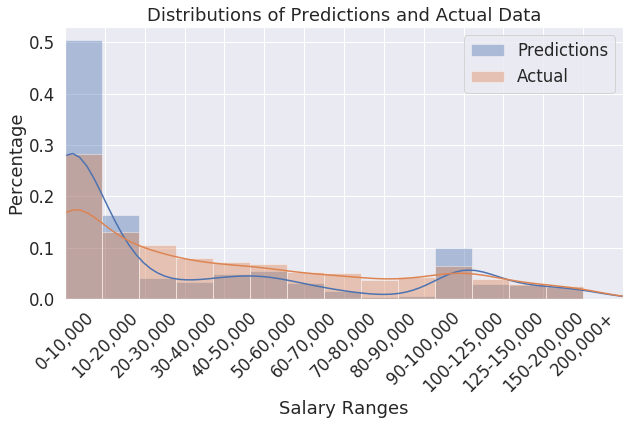

In [103]:
# plot distribution of predictions and actual data for each salary range
pca_predictions_series = pd.Series(pca_predictions)
f, ax = plt.subplots(figsize=(10,5))
g = sns.distplot(pca_predictions_series, bins=14)
g = sns.distplot(y_test, bins=14)
plt.xlim(0,14)
xlabels = Q9_order
g.set_xticklabels(xlabels)
ax.set_xticks(range(14))
plt.legend(['Predictions', 'Actual'])
plt.title('Distributions of Predictions and Actual Data')
plt.ylabel('Percentage')
plt.xlabel('Salary Ranges')
plt.xticks(rotation=45)

### Conclusion

In summary, the purpose of this assignment is to predict salary ranges based on a survey conducted by Kaggle. The 5 major steps of the classification pipeline were discussed here with results shown. For future works, the logistic regression model can be improved by either having more samples that evenly support all salary ranges, or by simply reducing the amount of classes. For example, the model accuracy is likely to increase if the target classes were reduced to 5 from 14.